# Построение прогнозных моделей для оценки уровня удовлетворённости сотрудника и для предсказания увольнения сотрудника из компании

## Резюме исследования

**Заголовок:** Исследование сотрудников компании на предмет удовлетвеорённости работой и возможных причин увольнения

**Описание проекта:** Компания предоставила данные с характеристиками сотрудников компании. Среди них — **уровень удовлетворённости сотрудника работой в компании**, **увольнение сотрудника из компании**. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на **отток сотрудников**. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

**Цель исследования:** Выявить закономерности и факторы, определяющие:
1. Уровень удовлетворенности сотрудника работой
2. Отток сотрудников
на исторических данных заказчика. Спрогнозировать заданные показатели на тестовой выборке. Дать рекомендации по итогам исследования.

**Ход исследования:**
1. Таргет - уровень удовлетворённости сотрудника работой в компании
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ количественных и категриальных признаков, корреляционный анализ признаков
* Формирование пайплайна и обучение модели регрессии (таргет **уровень удовлетворённости сотрудника работой в компании**), оценка её качества

2. Таргет - увольнение сотрудника из компании
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ количественных и категриальных признаков, корреляционный анализ признаков
* Доработка датасета (добавление признака **уровень удовлетворённости сотрудника работой в компании** в тренировочную и тестовую выборки)
* Формирование пайплайна и обучение модели с учителем бинарной классификации (таргет **увольнение сотрудника из компании**), оценка её качества
* Анализ важности признаков
* Формирование рекомендаций по уменьшению оттока сотрудников

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций

## Описание данных

| Поле | Категория | Описание |
|-------------------------|-------------------------|--------------------------------------------------------------------------|
| id | Основные характеристики | Уникальный идентификатор сотрудника |
| dept | Основные характеристики | Отдел, в котором работает сотрудник |
| level | Основные характеристики | Уровень занимаемой должности |
| workload | Основные характеристики | Уровень загруженности сотрудника (в условных единицах) |
| employment_years | Опыт и достижения | Длительность работы в компании (в годах) |
| last_year_promo | Опыт и достижения | Наличие повышения за последний год (да/нет) |
| last_year_violations | Оценка эффективности | Наличие нарушений трудового договора за последний год (да/нет) |
| supervisor_evaluation | Оценка эффективности | Оценка качества работы сотрудника руководителем |
| salary | Оценка эффективности | Ежемесячная зарплата сотрудника |
| job_satisfaction_rate | Целевой признак | Уровень удовлетворённости сотрудника работой в компании |

## Импорт библиотек

In [1016]:
!pip install phik -q
!pip install shap -q
!pip install numpy==1.22 -q
!pip install matplotlib==3.5.3 -q

In [1017]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import phik
import time
import shap

# загружаем библиотеки для проверки признаков на мультиколлениарность
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, KFold

from sklearn.inspection import permutation_importance

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

# Загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import svm
from sklearn.svm import SVC

from optuna.integration import OptunaSearchCV
from optuna import distributions

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, accuracy_score, confusion_matrix

from typing import Union, List, Dict

# Импорт метода для проверки нормальности распределения
from scipy.stats import shapiro

# Задаём настройки для разделения выборки
RANDOM_STATE = 42
VALIDATION_SIZE = 0.25

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 8);

# Настройка отображения
pd.set_option('display.max_columns', None)  # Все столбцы
pd.set_option('display.width', None)        # Ширина отображения
pd.set_option('display.max_colwidth', None)   # Максимальная ширина столбца
pd.set_option('display.float_format', '{:.2f}'.format)  # Формат чисел

## Классы и функции

### Класс для обработки датасета

In [1018]:
# Создадим классы для работы с датасетами и колонками

# Класс (датафрейм)
class Data:
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Данные должны быть типа pd.DataFrame')
        
        self.data = data
        self.X_train = None
        self.X_test_transformed = None
        self.y_train = None
        self.y_test = None
        
        self.selected_features = list(self.data.columns)
        
    def show_info(self): # Функция для анализа общей информации по датасету
        self.data.info()

    def print_head(self, n: int = 5): # Функция для ознакомления с данными
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Параметр n должен быть положительным целым числом больше нуля')
        return self.data.head(n)

    def unify_columns(self, df: pd.DataFrame): # Функция для перевода имён столбцов по словарю
        new_cols = {}
        for eng_key, ru_names in dict_column_translations.items():
            for ru_name in ru_names:
                if ru_name in df.columns:
                    new_cols[ru_name] = eng_key
                    break
        df.rename(columns=new_cols, inplace=True)
    
    def get_numeric_columns(self) -> list: # Функция для получения списка столбцов с числовыми данными
        return self.data.select_dtypes(include=['number']).columns.tolist()
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 1.0]): # Функция для ознакомления с количественными показателями
        numeric_columns = self.get_numeric_columns()
        return self.data[numeric_columns].describe(percentiles=percentiles)
    
    def count_duplicates(self): # Функция для подсчета явных дубликатов
        return self.data.duplicated().sum()
    
    def get_duplicate_rows(self): # Функция для вывода явных дубликатов
        self.data[self.data.duplicated(keep=False)]
    
    def get_string_columns(self): # Возвращает список строковых столбцов
        string_columns = self.data.select_dtypes(include=['object', 'string']).columns
        if string_columns.empty:
            print('Строковых столбцов нет')
            return []
        else:
            return string_columns
    
    def show_unique_vals_string_columns(self, column_name=None): # Выводит уникальные значения в строковых столбцах
        if column_name:
            columns = [column_name]
        else:
            columns = self.get_string_columns()
        
        for col in columns:
            unique_values = sorted(self.data[col].dropna().unique())
            print(f'Уникальные значения для столбца: {col}')
            print(f'Количество уникальных значений: {len(unique_values)}')
            print(unique_values)
            print('-' * 30)
    
    def drop_duplicate_rows(self): # Функция для удаления явных дубликатов
        self.data.drop_duplicates(keep='first', inplace=True)
        return self.data

    def count_missing_values(self): # Функция для подсчета строк с пропущенными значениями
        return self.data.isna().sum()
    
    def drop_na(self, column_name: str): # Функция для удаления строк с пропущенными значениями
        self.data.dropna(subset=[column_name], inplace=True)
        return self.data
    
    def count_rows(self): # Функция для подсчета строк
        return len(self.data)
    
    def to_lowercase_columns(self): # Фунция для приведения имен столбцов в нижний регистр
        self.data.columns = self.data.columns.str.lower()
        print(self.data.columns)
    
    def replace_multiple_column_name(self, replacements: dict): # Функция для множественной замены символов в названиях столбцов
        def replace_chars(value):
            for old, new in replacements.items():
                value = value.replace(old, new)
            return value
        
        self.data.columns = self.data.columns.map(replace_chars)
        print(self.data.columns)
        
    def process_string_columns(self, columns, replacements=dict, lowercase_list=None):
        for col in columns:
            col_obj = Column(self.data, col)
            
            if lowercase_list and col in lowercase_list:
                col_obj.to_lowercase_rows()
                
            if replacements:
                col_obj.replace_strings(replacements)
                
            self.show_unique_vals_string_columns(column_name=col)
    
    def convert_columns_to_float(self, column_names: list[str], replacements: Union[Dict, None] = None): # Функция для замены типа данных на 'float'
        for col in column_names:
            if col in self.data.columns:
                col_obj = Column(self.data, col)
                if replacements:
                    col_obj.replace_strings(replacements)
                col_obj.change_type('float')
                print(f'Тип данных для столбца {col} изменен на {col_obj.get_type()}')
                
    def modify_data(self, index: str, columns: str, values: str, column_rename: Dict, column_order: List):
        '''Функция для трансформации датасета с выделением периодов в отдельные столбцы'''
        transformed_data = (self.data.pivot(index=index, columns=columns, values=values)\
              .reset_index()\
              .rename(columns=column_rename)\
              .rename_axis(None, axis=1)
             )\
        .copy()

        # Определяем желаемый порядок столбцов
        transformed_data = transformed_data[column_order]

        # Создаем новый экземпляр класса Data()
        new_data = Data(transformed_data)
        
        # Можно сохранить оригинальное имя с суффиксом
        new_data.name = f'{self.name}' if hasattr(self, 'name') else 'modified_dataset'

        # Возвращаем результат
        return new_data

    
    # Подготовка данных для тестирование модели, оценка качества модели
    
    def split(self, target_column: str, random_state=42, stratify=None): # Функция для разделения выборки на тренировочную и тестовую
        if target_column not in self.data.columns:
            raise ValueError(f"Целевая колонка '{target_column}' отсутствует в данных")
        
        X = self.data.drop(columns=target_column)
        y = self.data[target_column]
        
        stratify_param = y if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, random_state=random_state, stratify=stratify_param
        )
        
        print(f'Разделение завершено: обучающая выборка - {self.X_train.shape}, тестовая - {self.X_test.shape}')

        
    def select_features(self, features: list[str]): # Функция для отбора фичей
        # Проверяем, все ли запрошенные признаки есть в исходных данных
        missing = [f for f in features if f not in self.data.columns]
        if missing:
              raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        # Отбираем только нужные признаки
        self.selected_features = features
        print(f'Выбраны следующие признаки: {features}')
        
    def reset_features(self):
        self.selected_features = list(self.data.columns)
        print('Сброшен выбор признаков — используются все признаки.')
        
    def count_linear_regression_metrics(self, y_true_list: list, y_pred_list: list, model_names: list[str]) -> pd.DataFrame: # Функция для подсчета метрик линейной регресии
        if not (len(y_true_list) == len(y_pred_list) == len(model_names)):
            raise ValueError('Все входные списки должны быть одинаковой длины.')

        results = []

        for y_true, y_pred, name in zip(y_true_list, y_pred_list, model_names):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            results.append({
                'Model': name,
                'MSE': round(mse, 2),
                'RMSE': round(rmse, 2),
                'MAE': round(mae, 2),
                'R2': round(r2, 2)
            })

        return pd.DataFrame(results)

    
    def count_logistic_regression_metrics(self, y_true: np.array, y_pred: np.array): # Функция для подсчета метрик логистической регресии
    
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    
        results = {
            'accuracy': round(accuracy, 2),
            'recall': round(recall, 2),
            'precision': round(precision, 2)
        }

        return pd.DataFrame([results])


    def threshold_table(self, y_true: np.array, y_proba): # Функция для вывода таблицы метрик Precision, Recall при разных порогах
        
        thresholds = np.arange(0.0, 1.0, 0.02)  # от 0 до 1 с шагом 0.02
        rows = []
    
        total_class_1 = (y_true == 1).sum()  # сколько всего объектов класса 1
    
        for thr in thresholds:
            y_pred = (y_proba >= thr).astype(int)  # применяем порог
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            predicted_count = y_pred.sum()
            accuracy = accuracy_score(y_true, y_pred)

            # Считаем False Positive и False Negative
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()
    
            rows.append({
                'Порог': round(thr, 2),
                'Recall': round(recall, 3),
                'Precision': round(precision, 3),
                'Accuracy':accuracy,
                'Количество False Positive':fp,
                'Количество False Negative':fn,
                'Число предсказанных объектов': predicted_count,
                'Всего объектов класса 1': total_class_1
            })

        return pd.DataFrame(rows)

### Класс для обработки столбцов

In [1019]:
# Класс (столбец датафрейма)
class Column():
    def __init__(self, data: pd.DataFrame, column_name: str):
        self.data = data
        self.column_name = column_name
        self.series = data[column_name]
        
        if column_name not in self.data.columns:
            raise KeyError(f'Столбец "{column_name}" не найден в датафрейме')
    
    def describe_numeric(self): # Функция для ознакомления с количественными показателями
        return self.series.describe()
    
    def count_values(self): # Функция для вывода и подсчета уникальных значений
        return self.series.value_counts()
    
    def fill_na(self, new_value): # Функция для заполнения пропущенных значений
        self.data[self.column_name].fillna(new_value, inplace=True)
        self.series = self.data[self.column_name]
        return self.series
    
    def replace_strings(self, replacements):
        for old, new in replacements.items():
            self.data[self.column_name] = self.data[self.column_name].str.replace(old, new, regex=False)
            self.series = self.data[self.column_name]
        return self.series
    
    def change_type(self, new_type): # Функция для изменения типов данных
        self.data[self.column_name] = self.data[self.column_name].astype(new_type)
        self.series = self.data[self.column_name]
        return self.series
    
    def get_type(self): # Функция для выводы типа данных
        return self.series.dtype
    
    def to_lowercase_rows(self): # Фунция для приведения значений в нижний регистр
        self.data[self.column_name] = self.data[self.column_name].str.lower()
        self.series = self.data[self.column_name]
        return self.series
    
    def print_unique(self): # Функция для отображения уникальных значений в колонке
        return self.series.unique()

### Класс для обработки групп датасетов

In [1020]:
# Создадим класс для работы с группой датасетов

class DatasetManager:
    def __init__(self, datasets: dict[str, Data]):
        self.datasets = datasets
        
    def show_info_all(self): # Выводит общую информацию о каждом датасете
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.show_info()
            print('-' * 30)
            print()
            
    def print_head_all(self, n = 5): # Выводит заданное количество строк в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.print_head(n))
            print('-' * 30)
            
    def describe_numeric_all(self, percentiles=[0.25, 0.5, 0.75, 0.95, 0.99, 0.995, 0.997, 0.999]): # Выводит описательную статистику в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.describe_numeric(percentiles=percentiles))
            print('-' * 30)

    def to_lowercase_columns_all(self): # Приводит имена столбцов к виду snake_case в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.to_lowercase_columns()
            print('-' * 30)
            
    def replace_multiple_column_name_all(self, replacements): # Проводит замену символов в именах столбцов с использованием словаря
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.replace_multiple_column_name(replacements)
            print('-' * 30)
            
    def get_duplicate_rows_all(self): # Показывает явные дубликаты в столбцах датасетов
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.get_duplicate_rows()
            print('-' * 30)

    def drop_duplicate_rows_all(self, exclude: Union[list[str], None] = None):
        exclude = exclude or []  # если None, то делаем пустой список
        
        for name, df in self.datasets.items():
            if name in exclude:
                print(f'Пропущен датасет: {name}')
                print('-' * 30)
                continue
            
            print(f'Имя датасета: {name}')
            print(f'Количество строк всего: {df.count_rows()}')
            print(f'Количество дубликатов в {name}: {df.count_duplicates()}')
            df.drop_duplicate_rows()
            print(f'Количество строк после удаления дубликатов: {df.count_rows()}')
            print('-' * 30)
            
    def show_unique_vals_string_columns_all(self): # Выводит уникальные значения в столбцах с строковым типом данных в разрезе датасета
        for name, df in self.datasets.items():
            print(f'Имя датасета: {name}')
            print()
            df.show_unique_vals_string_columns()
            print()
            print('/-' * 30)
            print()

### Класс для построения графиков

In [1021]:
# Создадим класс для визуализаций

class Visualizer:
    def __init__(self, data: pd.DataFrame, translations: dict = None):
        self.translations = translations or {}
        self.data = data.rename(columns=self.translations)
        
    def boxplot(self, y: Union[str, list[str]], x: str = None, hue: str = None): # Функция для построения ящика с усами
        # Приводим y к списку
        y_list = [y] if isinstance(y, str) else y
        
        columns_to_check = y_list.copy()
        
        if hue:
            columns_to_check.append(hue)
        elif x:
            columns_to_check.append(x)

        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')

        df = self.data

        # Создание сабплотов
        n = len(y_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, y_label in enumerate(y_list):
            ax = axes[i]

            sns.boxplot(
                data=df,
                x=x,
                y=y_label,
                hue=hue,
                ax=ax
            )

            
            title = f'Диаграмма размаха: {y_label}'
            if x:
                title += f', срез: {x}'
            elif hue:
                title += f' и {hue}'
            ax.set_title(title)

        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
        
    def barplot(self, x: Union[str, list[str]], hue: str = None): # Функция для построения столбчатой диаграммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list.copy()
        
        if hue:
            columns_to_check.append(hue)
            
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
            
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Функция для добавления подписей с увеличенными границами
        def add_value_labels(ax):
            # Получаем текущие пределы оси X
            xmin, xmax = ax.get_xlim()
            # Увеличиваем пределы на 20% (можно настроить под свои нужды)
            ax.set_xlim(xmin, xmax * 1.2)  # Увеличиваем только правую границу

            for p in ax.patches:
                width = p.get_width()
                ax.annotate(
                    f'{int(width)}', 
                    xy=(width, p.get_y() + p.get_height() / 2),
                    xytext=(5, 0),  # Отступ от столбца
                    textcoords='offset points',
                    ha='left', 
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.5, boxstyle="round,pad=0.2")
                )

        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
                    
            # Подсчет частот
            if hue:
                df_count = (df.groupby([x_label, hue]).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
            else:
                df_count = (df.groupby(x_label).size().sort_values().reset_index(name='count')\
                            .sort_values(by='count', ascending=False))
                
            # Преобразуем категории в строки, если они числовые
            df_count[x_label] = df_count[x_label].astype(str)
               
            # Создаем горизонтальный барплот
            if hue:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    hue=hue,
                    ax=ax
                )
               
            else:
                sns.barplot(
                    data=df_count,
                    x='count',
                    y=x_label,
                    color='blue',
                    ax=ax
                )
                
            # Добавляем подписи с увеличенными границами
            add_value_labels(ax)

            
            # Заголовок и подписи осей
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')

            # Настройка отображения
            ax.tick_params(axis='x', labelrotation=0)
            ax.tick_params(axis='y', labelrotation=0)
                
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        ax.margins(x=0.1)  # Добавляем отступы
        plt.tight_layout(rect=[0, 0, 1, 1], pad=3)
        plt.show()
         
        
    def histplot(self, x: Union[str, list[str]], measurement: Union[str, list[str]] , hue: str = None): # Функция для построения гистограммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        measurement_list = [measurement] if isinstance(measurement, str) else measurement

        # Проверка согласованности размеров
        if len(x_list) != len(measurement_list):
            raise ValueError('Длины x_list и measurement_list должны совпадать')
        
        columns_to_check = x_list.copy() # Формируем список столбцов для проверки
        
        if hue:
            columns_to_check.append(hue)
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        if n == 1:
            fig, axes = plt.subplots(figsize=(8, 6))
            axes = [axes]
        else:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
            axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, (x_label, measurement_label) in enumerate(zip(x_list, measurement_list)):

            if pd.api.types.is_integer_dtype(df[x_label]) or pd.api.types.is_categorical_dtype(df[x_label]):
                bins = df[x_label].nunique()
            else:
                bins = 'sturges'
            
            ax = axes[i]
            
            sns.histplot(
                data=df,
                x=x_label,
                hue=hue,
                kde=True, # Показать плотность распределения
                element='step',
                ax=ax,
                bins=bins
            )
                        
            # Добавляем подписи осей
            ax.set_xlabel(f'{x_label}, {measurement_label}')
            ax.set_ylabel(f'Количество')
            if not hue:
                ax.set_title(f'Распределение {x_label}')
            else:
                ax.set_title(f'Распределение {x_label} в разрезе {hue}')
            
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
        
        
    def scatterplot(self, x: Union[str, list[str]], y: str, hue: str): # Функция для построения диаграммы рассеяния
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in x_list + [y, hue] if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            # Добавляем диаграмму рассеивания
            sns.scatterplot(
                data=df,
                x=x_label,
                y=y,
                hue=hue,
                alpha=0.7,
                palette='Set2',
                ax=ax
            )
            
            # Добавляем линию регрессии по каждой категории
            for category in df[hue].unique():
                subset = df[df[hue] == category]
                sns.regplot(
                    data=subset,
                    x=x_label,
                    y=y,
                    scatter=False,
                    ax=ax,
                    label=category
                )
                
            ax.set_title(f'Зависимость {y} от {x_label}')
            ax.legend().set_title(hue)
            
        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

## Задача регрессии

### Загрузка данных

In [1022]:
# Загрузим датафреймы
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep=',')

df_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

df_test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [1023]:
# Инициализируем все датафреймы
df_train = Data(df_train)
df_test_features = Data(df_test_features)
df_test_target = Data(df_test_target)

# Составим словарь с именами датафреймов
datasets = {
    'df_train': df_train,
    'df_test_features': df_test_features,
    'df_test_target': df_test_target
}

# Передаем объекты для последующего вывода информации
manager = DatasetManager(datasets)

### Знакомство с данными

In [1024]:
# Ознакомимся с данными
manager.print_head_all(10)

Датасет: df_train



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


------------------------------
Датасет: df_test_features



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


------------------------------
Датасет: df_test_target



,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


------------------------------


### Анализ общей информации

In [1025]:
# Проанализируем общую информацию
manager.show_info_all()

Датасет: df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
------------------------------

Датасет: df_test_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          

### Промежуточные выводы

**df_train**
- **Количество строк:** 4000  
- **Пропущенные значения:** есть (`dept` – 6, `level` – 4) - обрабатывать будем на этапе формирования пайплайна модели
- **Необходимые преобразования:**  
  - Обработать пропущенные значения (`dept`, `level`)  
- **Типы данных:** корректировка не требуется  

---

**df_test_features**
- **Количество строк:** 2000  
- **Пропущенные значения:** есть (`dept` – 2, `level` – 1) - обрабатывать будем на этапе формирования пайплайна модели
- **Необходимые преобразования:**  
  - Обработать пропущенные значения (`dept`, `level`)  
- **Типы данных:** корректировка не требуется  

---

**df_test_target**
- **Количество строк:** 2000  
- **Пропущенные значения:** отсутствуют  
- **Необходимые преобразования:** отсутствуют  
- **Типы данных:** корректировка не требуется  


## Предобработка данных

### Обработка дубликатов

#### Обработка явных дубликатов

In [1026]:
# Посмотрим на явные дубликаты в датасетах
manager.get_duplicate_rows_all()

Датасет: df_train

------------------------------
Датасет: df_test_features

------------------------------
Датасет: df_test_target

------------------------------


Явные дубликаты не обнаружены

#### Поиск неявных дубликатов

In [1027]:
# Выводим уникальные значения в столбцах с строковым типом данных
manager.show_unique_vals_string_columns_all()

Имя датасета: df_train

Уникальные значения для столбца: dept
Количество уникальных значений: 5
['hr', 'marketing', 'purchasing', 'sales', 'technology']
------------------------------
Уникальные значения для столбца: level
Количество уникальных значений: 3
['junior', 'middle', 'sinior']
------------------------------
Уникальные значения для столбца: workload
Количество уникальных значений: 3
['high', 'low', 'medium']
------------------------------
Уникальные значения для столбца: last_year_promo
Количество уникальных значений: 2
['no', 'yes']
------------------------------
Уникальные значения для столбца: last_year_violations
Количество уникальных значений: 2
['no', 'yes']
------------------------------

/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-

Имя датасета: df_test_features

Уникальные значения для столбца: dept
Количество уникальных значений: 6
[' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology']
------------------------------
Уникальные значения для сто

Обнаружены опечатки и пустые значения, замаскированные под строковые:

**df_train**
* столбец `level` опечатка в категории senior (указано sinior)

**df_test_features**
* столбцы `dept`, `workload` есть пустые значения
* столбец `level` аналогичная опечатка в категории senior (указано sinior)

**df_test_target**
* Отсутствуют строковые данные

#### Обработка неявных дубликатов

In [1028]:
# Создадим список датасетов
df_process_string_columns = [df_train, df_test_features]

# Замена значений из словаря на корректный вариант
for data in df_process_string_columns:
    data.process_string_columns(
        columns=['level'],
        replacements={'sinior':'senior'}
    )

Уникальные значения для столбца: level
Количество уникальных значений: 3
['junior', 'middle', 'senior']
------------------------------
Уникальные значения для столбца: level
Количество уникальных значений: 3
['junior', 'middle', 'senior']
------------------------------


### Промежуточные выводы

* Явные дубликаты не обнаружены
* Неявные дубликаты не обнаружены
* Опечатки исправлены
* Обнаружены некорректные значения ' ' в столбцах `dept`, `workload`в тестовой выборке (в тренировочной выборке таких значений нет)

## Исследовательский анализ данных

### Описательная статистика

In [1029]:
# Посмотрим на параметры столбцов с числовыми значениями
manager.describe_numeric_all()

Датасет: df_train



,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.00,4000.00,4000.00,4000.00,4000.00
mean,544957.62,3.72,3.48,33926.70,0.53
std,257883.10,2.54,1.01,14900.70,0.23
min,100954.00,1.00,1.00,12000.00,0.03
25%,322836.75,2.00,3.00,22800.00,0.36
50%,534082.50,3.00,4.00,30000.00,0.56
75%,771446.00,6.00,4.00,43200.00,0.71
95%,947767.35,9.00,5.00,62400.00,0.87
99%,987689.72,10.00,5.00,78012.00,0.93
99.5%,992215.75,10.00,5.00,81600.00,0.95


------------------------------
Датасет: df_test_features



,id,employment_years,supervisor_evaluation,salary
count,2000.00,2000.00,2000.00,2000.00
mean,552765.21,3.67,3.53,34066.80
std,253851.33,2.54,1.00,15398.44
min,100298.00,1.00,1.00,12000.00
25%,339052.00,1.00,3.00,22800.00
50%,550793.00,3.00,4.00,30000.00
75%,765763.75,6.00,4.00,43200.00
95%,948432.10,9.00,5.00,62400.00
99%,991523.58,10.00,5.00,81600.00
99.5%,994718.61,10.00,5.00,86400.00


------------------------------
Датасет: df_test_target



,id,job_satisfaction_rate
count,2000.00,2000.00
mean,552765.21,0.55
std,253851.33,0.22
min,100298.00,0.03
25%,339052.00,0.38
50%,550793.00,0.58
75%,765763.75,0.72
95%,948432.10,0.87
99%,991523.58,0.94
99.5%,994718.61,0.97


------------------------------


Выбросы по рассматриваемым признакам не обнаружены

### Диаграммы размаха

#### Диаграммы размаха df_train

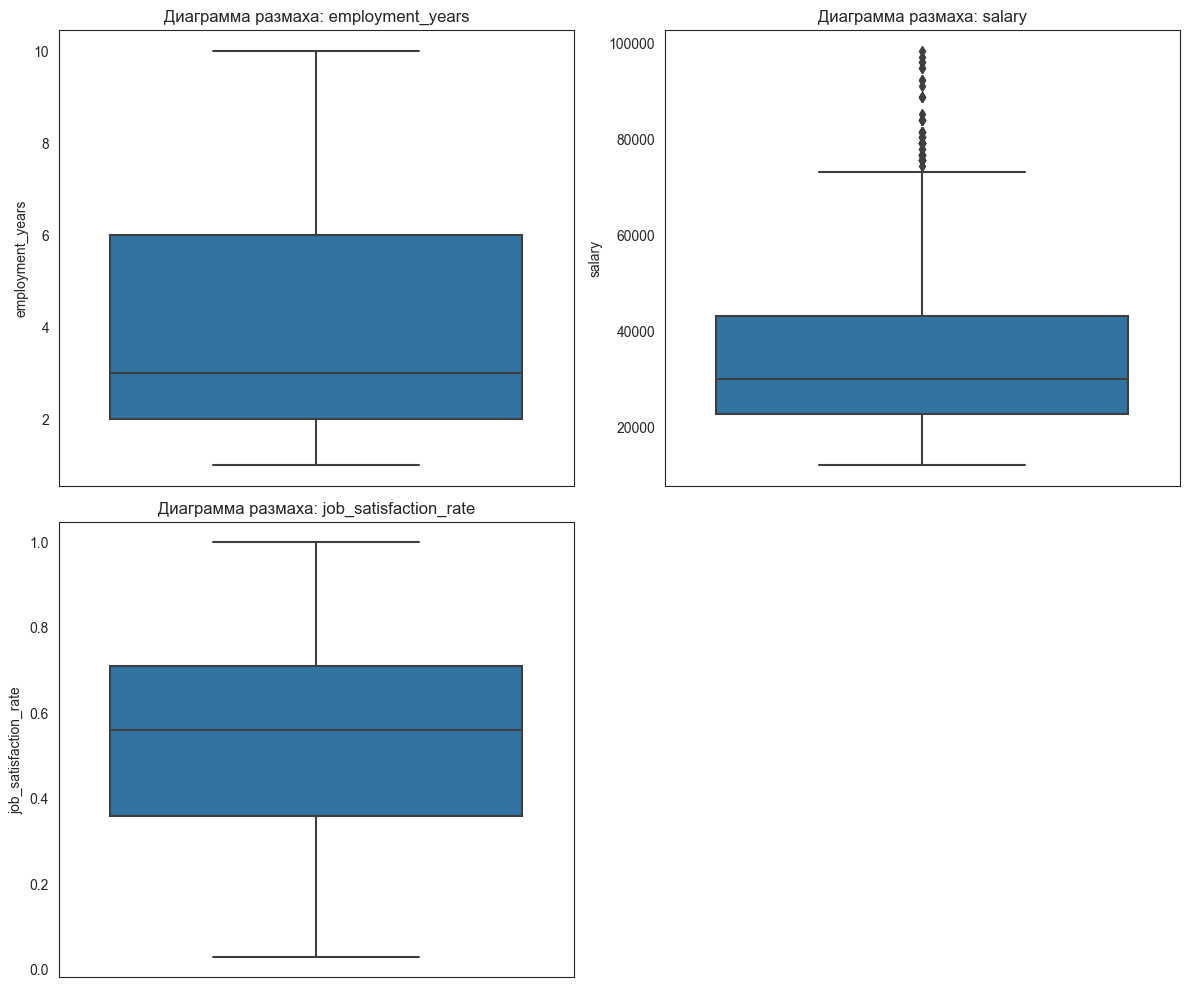

In [1030]:
# Создаем визуализатор
viz_train = Visualizer(df_train.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_train.boxplot(y=['employment_years', 'salary', 'job_satisfaction_rate'])

#### Диаграммы размаха df_test_features

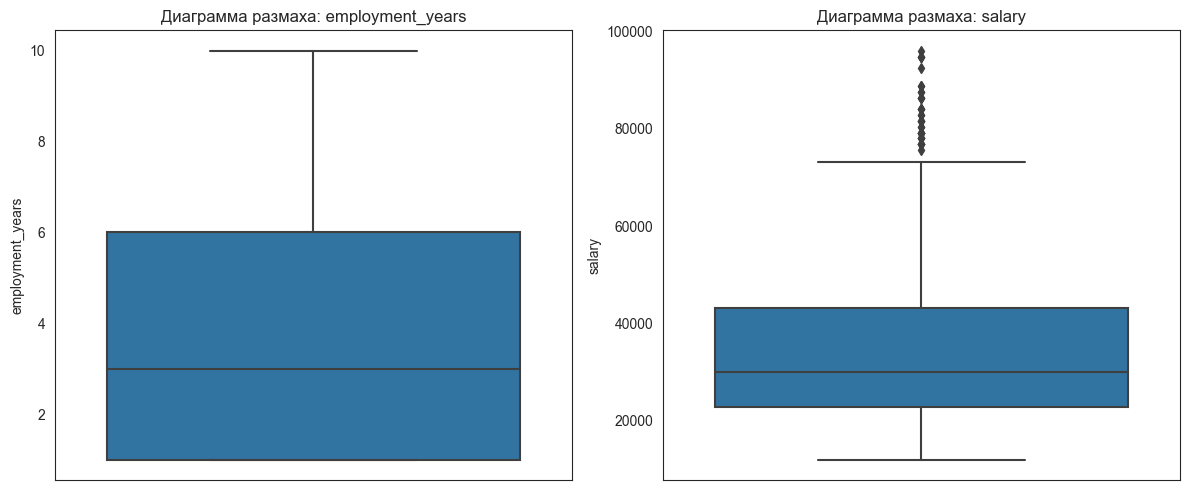

In [1031]:
# Создаем визуализатор
viz_test_features = Visualizer(df_test_features.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_test_features.boxplot(y=['employment_years', 'salary'])

#### Диаграммы размаха df_test_target

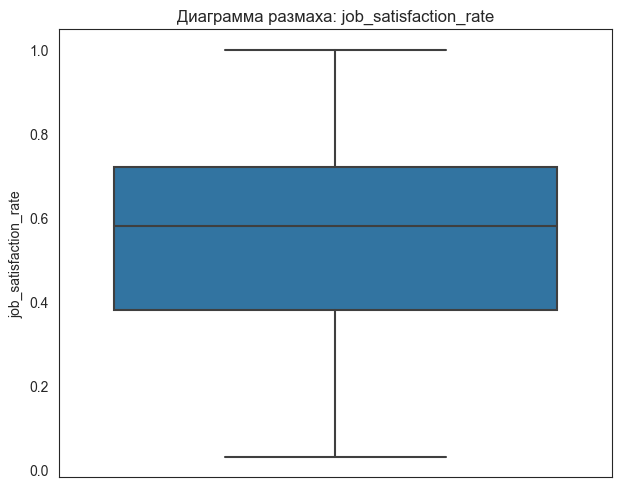

In [1032]:
# Создаем визуализатор
viz_test_target = Visualizer(df_test_target.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_test_target.boxplot(y=['job_satisfaction_rate'])

#### Комментарии к диаграммам размаха

* Есть объяснимые выбросы по зарплате в районе выше 70_000 - очевидно, что самая высокая зарплата у мЕньшего числа сотрудников
* По длительности работы в компании медианное значение выборки в районе 3-х лет (имеет дискретный характер, будем строить барплот)
* Медианное значение уровня удовлетворённости работой в районе чуть выше 0.5
* У тренировочных и тестовых данных схожий диапазон значений и схожие медианные значения

### Диаграммы распределения

#### Диаграммы распределения df_train

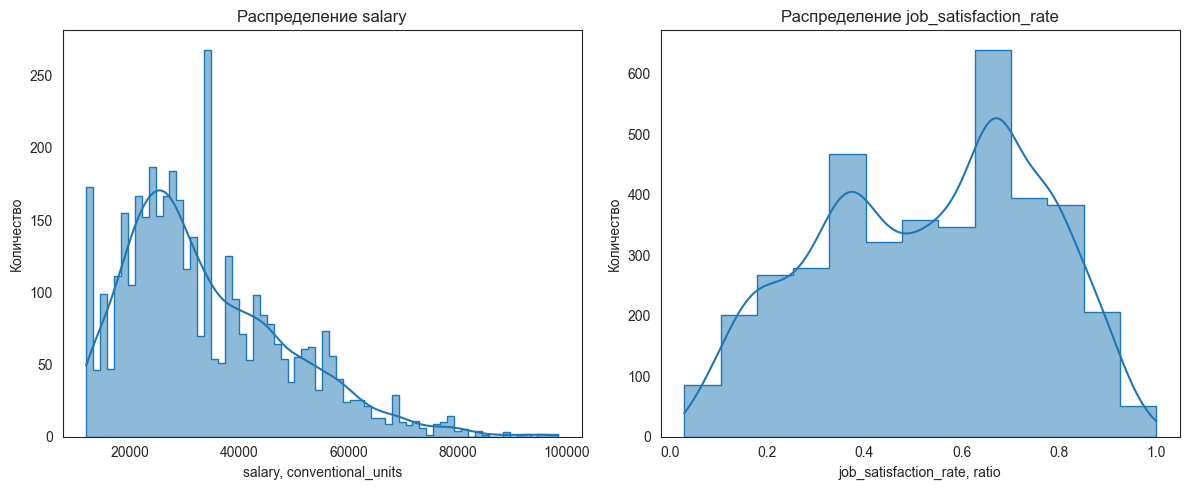

In [1033]:
# Строим график
viz_train.histplot(x=['salary', 'job_satisfaction_rate'], measurement=['conventional_units', 'ratio'])

**Проверка на нормальность распределения:**

In [1034]:
# Создаем список столбцов для проведения теста Шапиро-Уилка
df_train_columns = ['salary', 'job_satisfaction_rate']

# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
for column in df_train_columns:
    display(f'Результат теста Шапиро_Уилка для столбца {column}: {shapiro(df_train.data[column])}')
    print('*' * 5)

'Результат теста Шапиро_Уилка для столбца salary: ShapiroResult(statistic=0.938750684261322, pvalue=8.392701043565667e-38)'

*****


'Результат теста Шапиро_Уилка для столбца job_satisfaction_rate: ShapiroResult(statistic=0.9708925485610962, pvalue=8.947486298599193e-28)'

*****


**Вывод о нормальности распределения**
* p_value для значений всех столбцов значительно меньше 0.05, отвергаем нулевую гипотезу - значения по столбцам `salary`, `job_satisfaction_rate` **НЕ распределены нормально**.

#### Диаграммы распределения df_test

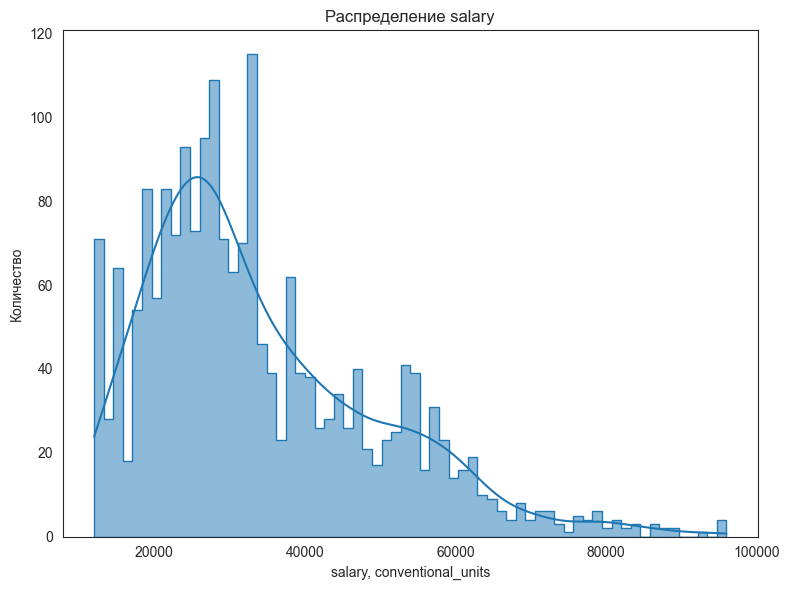

In [1035]:
# Строим график
viz_test_features.histplot(x=['salary'], measurement=['conventional_units'])

**Проверка на нормальность распределения:**

In [1036]:
# Создаем список столбцов для проведения теста Шапиро-Уилка
df_test_columns = ['salary']

# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
for column in df_test_columns:
    display(f'Результат теста Шапиро_Уилка для столбца {column}: {shapiro(df_test_features.data[column])}')
    print('*' * 5)

'Результат теста Шапиро_Уилка для столбца salary: ShapiroResult(statistic=0.9255349636077881, pvalue=2.1295018679835435e-30)'

*****


**Вывод о нормальности распределения**
* p_value для значений всех столбцов значительно меньше 0.05, отвергаем нулевую гипотезу - значения по столбцу `salary` **НЕ распределены нормально**.

#### Диаграммы распределения df_test_target

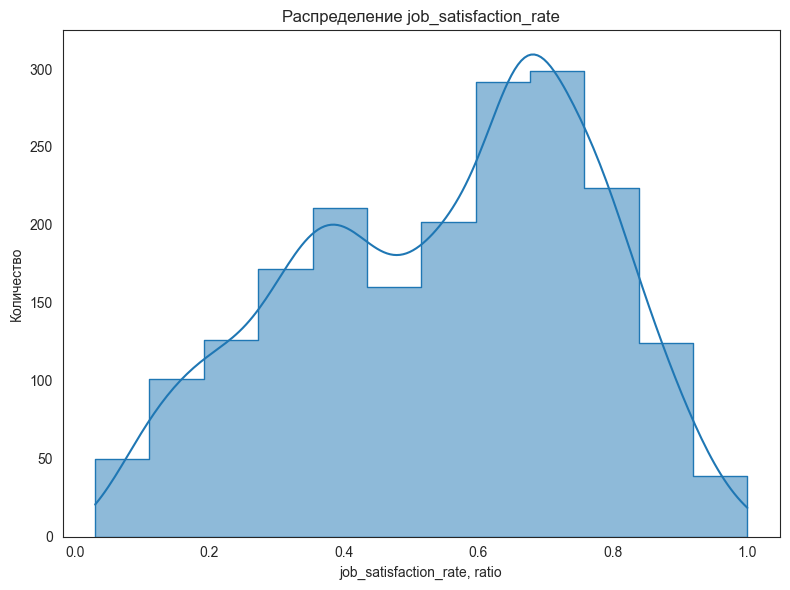

In [1037]:
# Строим график
viz_test_target.histplot(x=['job_satisfaction_rate'], measurement=['ratio'])

**Проверка на нормальность распределения:**

In [1038]:
# Создаем список столбцов для проведения теста Шапиро-Уилка
df_test_target_columns = ['job_satisfaction_rate']

# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
for column in df_test_target_columns:
    display(f'Результат теста Шапиро_Уилка для столбца {column}: {shapiro(df_test_target.data[column])}')
    print('*' * 5)

'Результат теста Шапиро_Уилка для столбца job_satisfaction_rate: ShapiroResult(statistic=0.9699938893318176, pvalue=5.123790974287868e-20)'

*****


**Вывод о нормальности распределения**
* p_value для значений всех столбцов значительно меньше 0.05, отвергаем нулевую гипотезу - значения по столбцу `job_satisfaction_rate` **НЕ распределены нормально**.

Учитывая унимодальный вид распределения значений признака `job_satisfaction_rate` посмотрим дополнительно, как распределены значения в разрезе отделов и уровней занимаемой должности

#### Комментарии к диаграммам распределения

* Все непрерывные величины датасетов не распределены нормально
* По признаку `salary` имеется пик в районе 25-30 тыс. у.е.
* Значения по признаку `job_satisfaction_rate` принимают унимодальный вид с пиковыми значениями в районе 0.4 и 0.7 - это значит, что в выборке есть 2 крупные группы сотрудников: с высоким (0.7) и низким (0.4) уровнем удовлетворенности работой

### Построение диаграмм частот

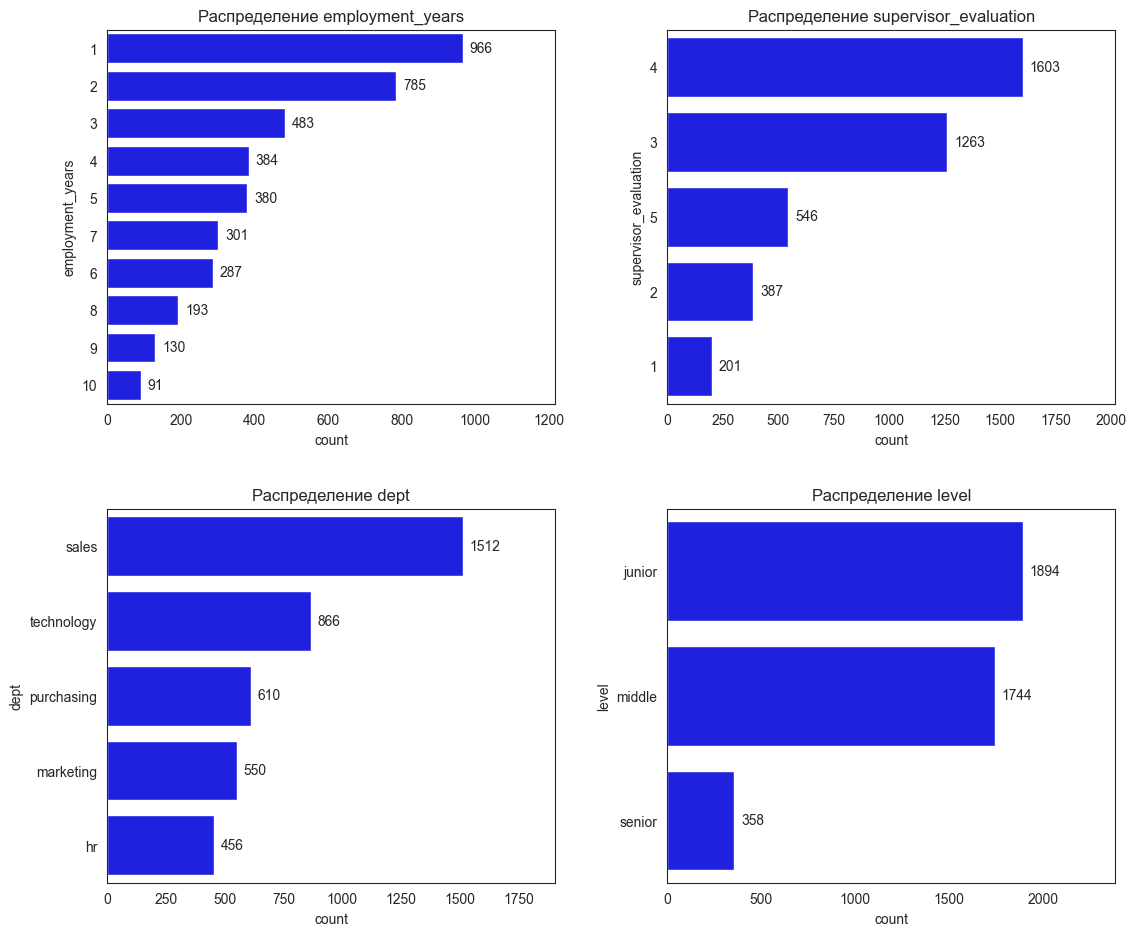

In [1039]:
# Строим график
viz_train.barplot(x=['employment_years','supervisor_evaluation', 'dept', 'level'])

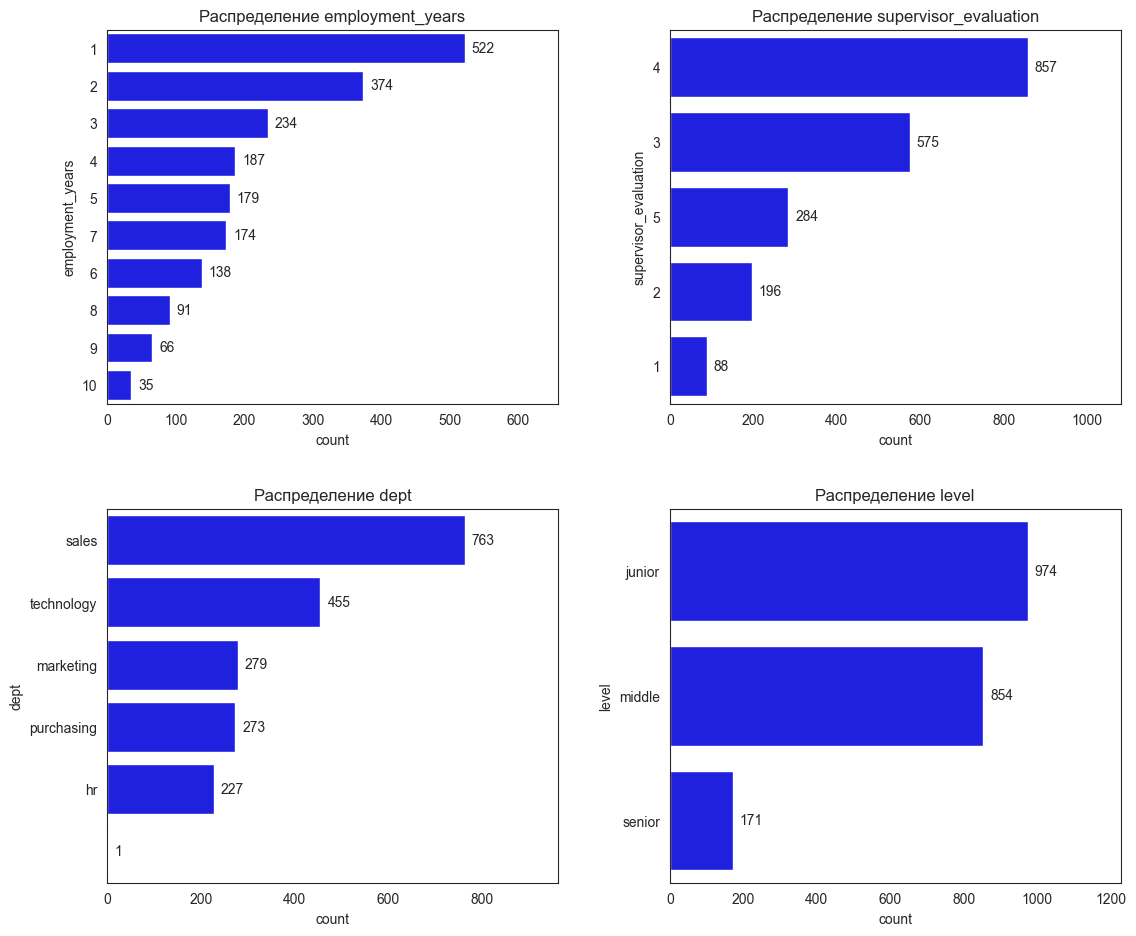

In [1040]:
# Строим график
viz_test_features.barplot(x=['employment_years','supervisor_evaluation', 'dept', 'level'])

#### Комментарии к диаграммам частот

* НаибОльшую долю сотрудников, заполнивших анкеты, составили сотрудники с опытом работы 1-2 года в компании (чем больше опыт работы, тем меньше доля таких сотрудников в выборке)
* Чаще всего качество работы сотрудники было оценено в 3-4 балла (меньше всего сотрудников получило 1 балл, что логично, иначе были бы вопросы к департаменту подбора персонала)

### Диаграммы рассеяния

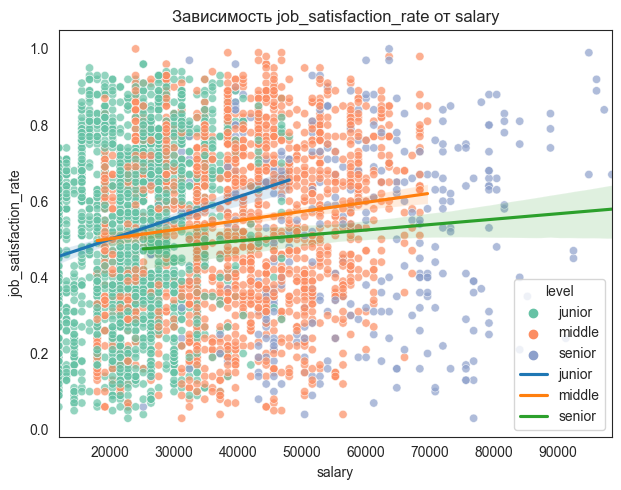

In [1041]:
# Строим диаграмму рассеяния
viz_train.scatterplot(x=['salary'], y='job_satisfaction_rate', hue='level')

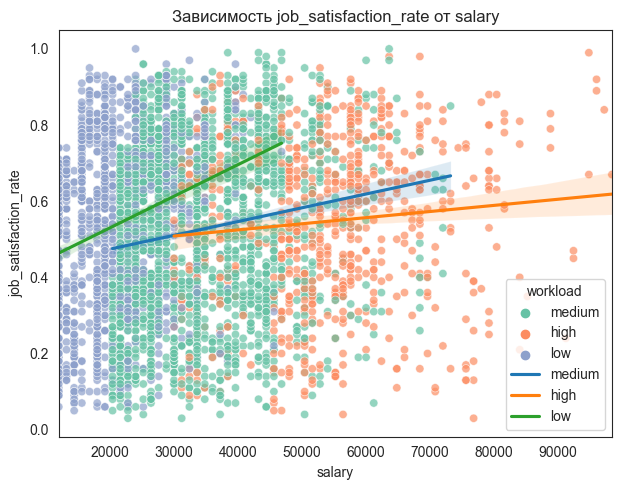

In [1042]:
# Строим диаграмму рассеяния
viz_train.scatterplot(x=['salary'], y='job_satisfaction_rate', hue='workload')

### Промежуточные выводы

**Диаграммы размаха**
* Есть объяснимые выбросы по зарплате в районе выше 70 тыс. у.е. - очевидно, что самая высокая зарплата у мЕньшего числа сотрудников
* По длительности работы в компании медианное значение выборки в районе 3-х лет (имеет дискретный характер, будем строить барплот)
* Медианное значение уровня удовлетворённости работой в районе чуть выше 0.5
* У тренировочных и тестовых данных схожий диапазон значений и схожие медианные значения

**Диаграммы распределения**
* Все непрерывные величины датасетов не распределены нормально
* По признаку `salary` имеется пик в районе 25-30 тыс. у.е.
* Значения по признаку `job_satisfaction_rate` принимают унимодальный вид с пиковыми значениями в районе 0.4 и 0.7 - это значит, что в выборке есть 2 крупные группы сотрудников: с высоким (0.7) и низким (0.4) уровнем удовлетворенности работой

**Диаграммы частот**
* НаибОльшую долю сотрудников, заполнивших анкеты, составили сотрудники с опытом работы 1-2 года в компании (чем больше опыт работы, тем меньше доля таких сотрудников в выборке)
* Чаще всего качество работы сотрудники было оценено в 3-4 балла (меньше всего сотрудников получило 1 балл, что логично, иначе были бы вопросы к департаменту подбора персонала)

**Диаграммы рассеяния**
* Построены диаграммы рассения - зависимость уровня удовлетворенности работой от зарплаты в разрезе квалификации и уровня загрузки работника:
    * чем выше квалификация, тем меньше линейная зависимость между зарплатой и уровнем удовлетворенности работника
    * чем выше загрузка работника, тем меньше линейная зависимость между зарплатой и уровнем удовлетворенности работника

**Подготовка данных на следующих этапах**
* Количественные непрерывные признаки: `salary` (следует масштабировать, т.к. шкалы значений между признаком и таргетом отличаются), `job_satisfaction_rate` - таргет
* Количественные признаки с дискретной природой: `employment_years`
* Категориальные номинальные признаки: `dept` - необходимо преобразовать с помощью OHE
* Категориальные порядковые признаки: `supervisor_evaluation`, `level`, `workload` - необходимо преобразовать с помощью OrdinalEncoder
* Бинарные признаки: `last_year_promo`, `last_year_violations` - необходимо преобразовать в 0 (no) /1 (yes)
* Перед подготовкой данных следует построить матрицу корреляции признаков для отбора важных признаков и ислючения мультиколлениарности между признаками

## Корреляционный анализ

### Построение матрицы корреляции

#### Тренировочные данные

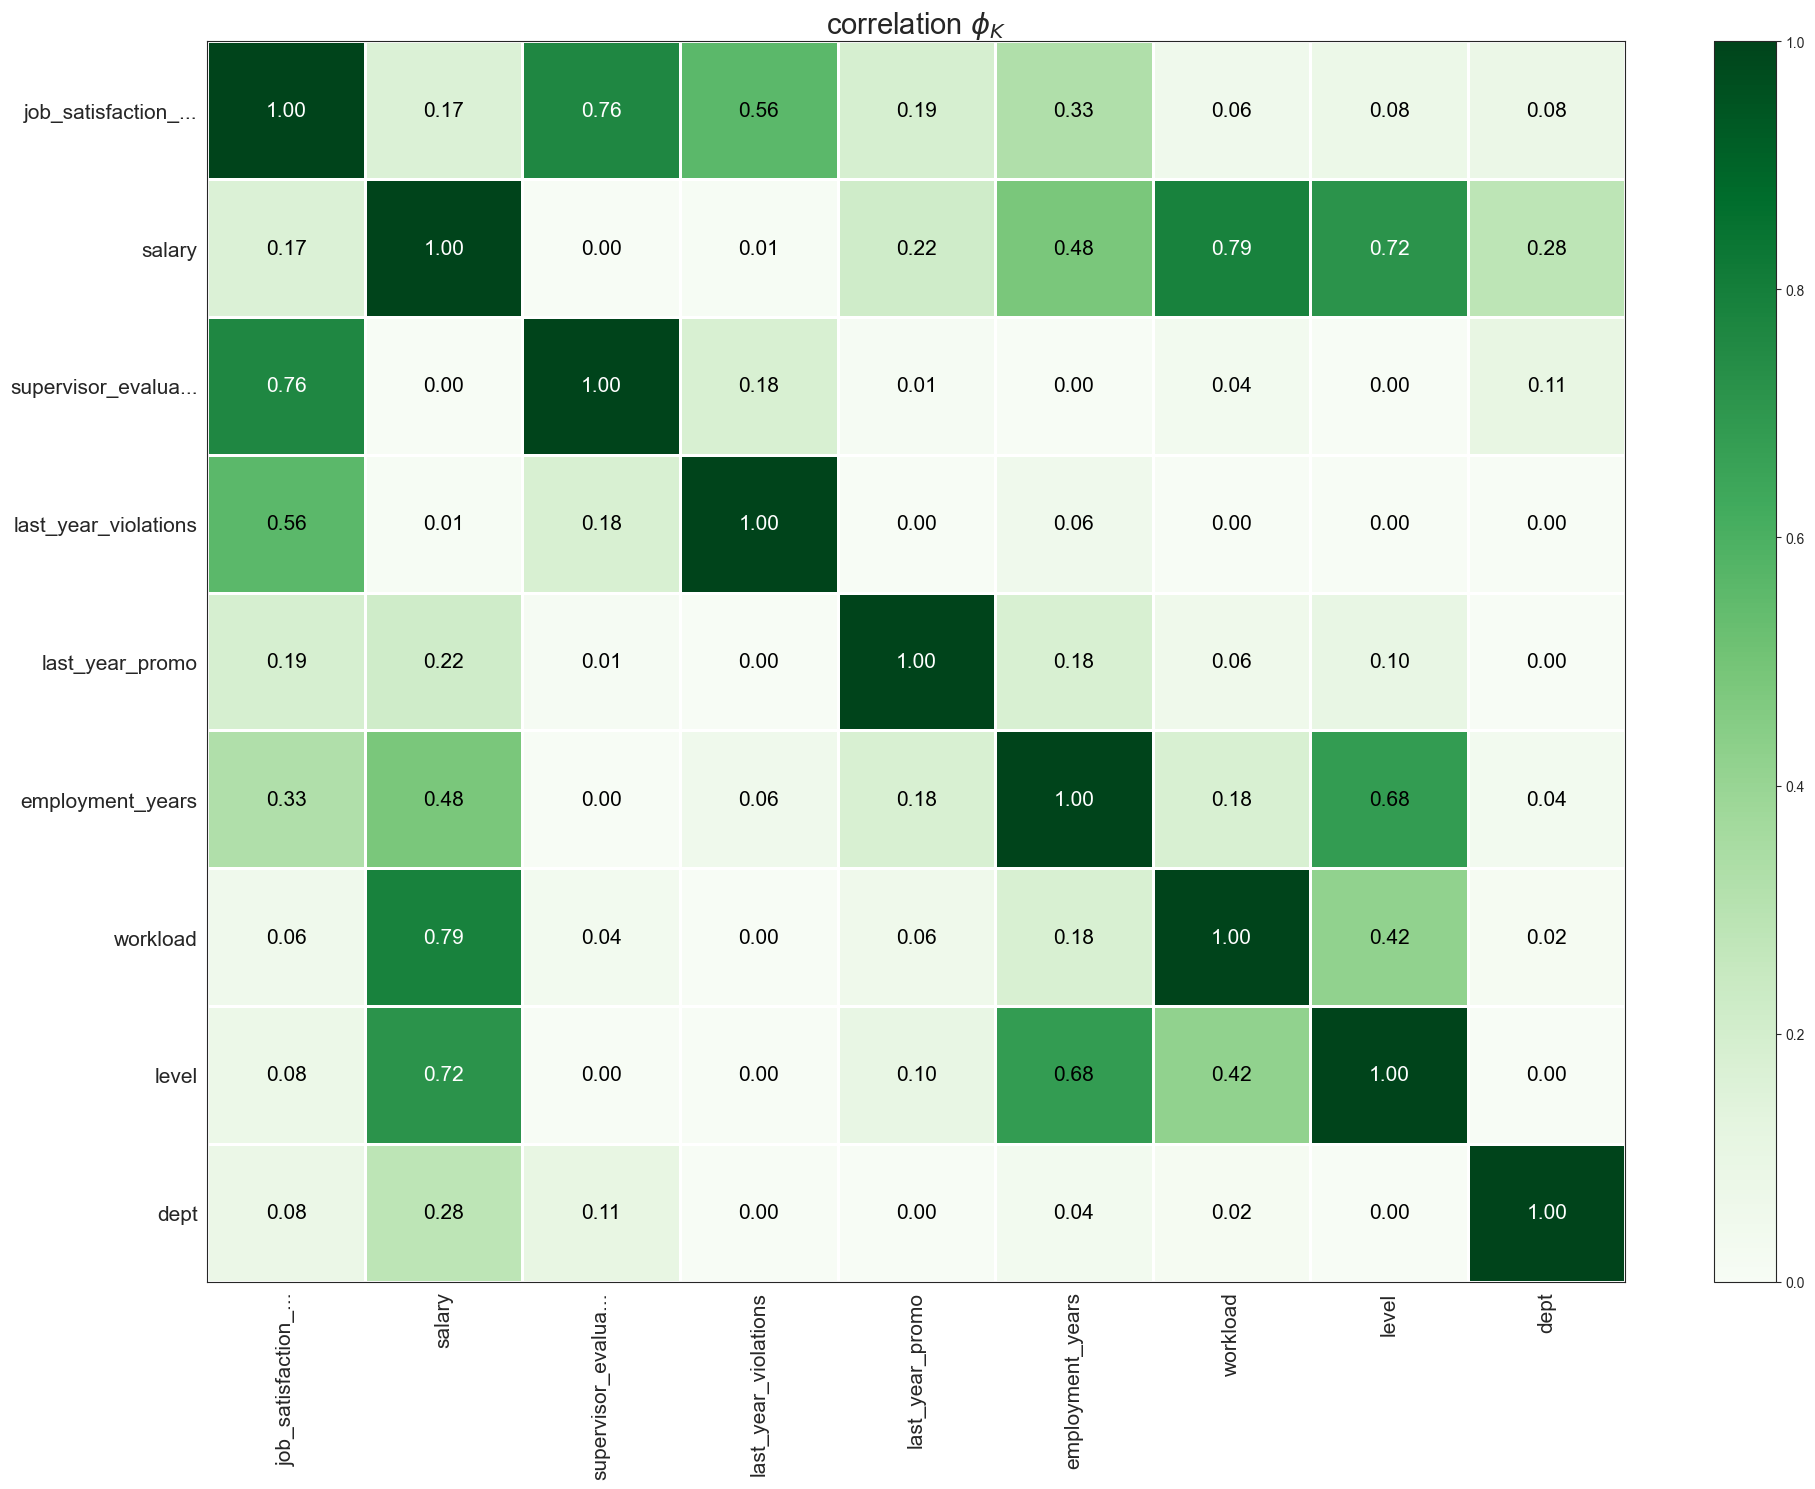

In [1043]:
# Создаём список с наименованиями непрерывных признаков
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']

# Считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_train.data.drop(['id'], axis=1), interval_cols=interval_cols)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Промежуточные выводы

* Мультиколлениарность признаков не обнаружена
* Самые важные признаки:
    * ежемесячная зарплата сотрудника
    * нарушал ли сотрудник трудовой договор за последний год
    * длительность работы в компании (в годах)

## Моделирование

### Особенности данных

**Категориальные признаки**

* **OneHotEncoder** (3 признака), т.к.:
* это бинарные признаки (они подходят для преобразования с помощью OHE в силу своей простоты)
    * `last_year_promo`
    * `last_year_violations`
*  между категориями этих признаков нет естественной иерархии, а следовательно - математической связи:
    *  `dept` **(имеются незаполненные значения)**

--

* **OrdinalEncoder** (3 признака), т.к. признаки имеют ранговый характер:
  * `supervisor_evaluation` - оценка по бальной системе
  * `level` - квалификация персонала **(имеются незаполненные значения)**
  * `workload` - загруженность сотрудника

--

**Количественные признаки**

*Масштабирование* требуется для следующих признаков:

* `salary`
* `employment_years`

### Выбор метрики качества модели

В качестве метрики качества модели выберем показатель SMAPE, для этого создадим функцию по расчету этой метрики

SMAPE — это метрика, которая измеряет ошибку прогнозов в процентном выражении, но делает это симметрично для наблюдения и прогноза.

Проблема обычного MAPE (Mean Absolute Percentage Error):
* Если истинное значение близко к нулю, дробь взлетает → MAPE сильно «скачет»
* Ошибка несимметрична: переоценка и недооценка дают разные проценты

SMAPE используется, чтобы сбалансировать это и сделать метрику устойчивой к нулям и симметричной

* Метрика SMAPE у лучшей модели должна быть не больше 15

In [1044]:
# Создаём функцию для оценки качества модели
def smape(y_true, y_pred):
    """
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE)
    для массивов NumPy или pandas Series.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Вычисляем SMAPE
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred))/ 2 + 1e-8 # Чтобы не делить на ноль
    
    # Избегаем ноль в знаменателе
    mask = denominator != 0
    
    # Расчитываем значение метрики
    smape_val = np.mean(numerator[mask] / denominator[mask]) * 100
    
    return smape_val


def smape_scorer(y_true, y_pred):
    return -smape(y_true, y_pred)  # чтобы RandomizedSearchCV мог максимизировать


# Создаём пользовательскую метрику
scorer = make_scorer(smape_scorer, greater_is_better=True) # Т.к. чем ниже значением SMAPE, тем лучше качество модели

### Формирование пайплайна

Строим регрессионную модель, т.к. необходимо предсказать значение непрерывной величины - оценки удовлетворенности работой

In [1045]:
# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тренировочную и валидационную
X_train = df_train.data.drop(columns=['job_satisfaction_rate', 'id'], axis=1)
y_train = df_train.data['job_satisfaction_rate']

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept', 'supervisor_evaluation']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years']

# ================== 3. Пайплайн обработки ==================

# Функция для замены пробелов на NaN
replace_space = FunctionTransformer(lambda X: X.replace(' ', 'unknown'))

# OHE пайплайн
ohe_pipe = Pipeline([
    ('replace_space', replace_space),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
                    ]
                   )

# Ordinal пайплайн
ord_pipe = Pipeline(
    [
        ('replace_space', replace_space),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['unknown', 'junior', 'middle', 'senior'],
                ['unknown', 'low', 'medium', 'high']
            ],
            handle_unknown='use_encoded_value', unknown_value=-1
        )
        )
    ]
)

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

# ================== 5. Сетка параметров ==================

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 3, 5, 7, 9, 11],
        'models__min_samples_leaf': [1, 2, 3, 4, 5],
        'models__max_features': [None, 1, 2, 3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

# ================== 6. RandomizedSearchCV ==================

# Инициализируем start для замера времени
start = time.time()

# Инициализируем класс для подбора гиперпараметров на 20 итераций
# значение кросс-валидации 5, метрика SMAPE
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучаем модель
randomized_search.fit(X_train, y_train)

# Считаем, сколько секунд прошло с начала запуска
randomized_search_search_time = time.time() - start
print(f'Search time:{randomized_search_search_time}')

# Выводим лучшую модель и метрики при обучении
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print (f'Метрика лучшей модели на тренировочной выборке: {np.abs(randomized_search.best_score_):.0f}')

# ================== 7. Стратифицированная CV на всём тренировочном датасете ==================

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    randomized_search.best_estimator_,
    X_train,
    y_train,
    cv=cv,
    scoring=scorer,
    n_jobs=-1
)
cv_scores = -cv_scores

print('SMAPE по стратифицированным фолдам тренировочного датасета:', [f'{score:.0f}' for score in cv_scores])
print(f'Средний SMAPE: {cv_scores.mean():.0f}')
print(f'Стандартное отклонение: {cv_scores.std():.1f}')

# ================== 8. Оценка на тестовой выборке ==================

# Индексируем по 'id' и сортируем
X_test = df_test_features.data.set_index('id').sort_index()
y_test = df_test_target.data.set_index('id')['job_satisfaction_rate'].sort_index()

# Проверка индексов
assert (X_test.index == y_test.index).all()

# Проверим работу модели на тестовой выборке
# Рассчитаем прогноз на тестовых данных
y_pred_regr = randomized_search.predict(X_test)
smape_val_test = smape(y_test.values, y_pred_regr)
print(f'Метрика SMAPE на тестовой выборке: {smape_val_test:.0f}')

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore
/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is sla

Search time:1.0112640857696533
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('replace_space',
                                                                   FunctionTransformer(func=<function <lambda> at 0x142817550>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                     

### Промежуточные выводы

* Для обучения выбраны 2 модели: LinearRegression() и DecisionTreeRegressor()
* Лучшей на обучении стала модель DecisionTreeRegressor()
* Метрика SMAPE:
    * на тренировочной выборке: 15
    * по стратифицированным фолдам тренировочного датасета: ['15', '14', '15', '15', '14']
    * на тестовой выборке: 14
* Условие задачи по значению метрики <= 15 выполнено

## Анализ остатков

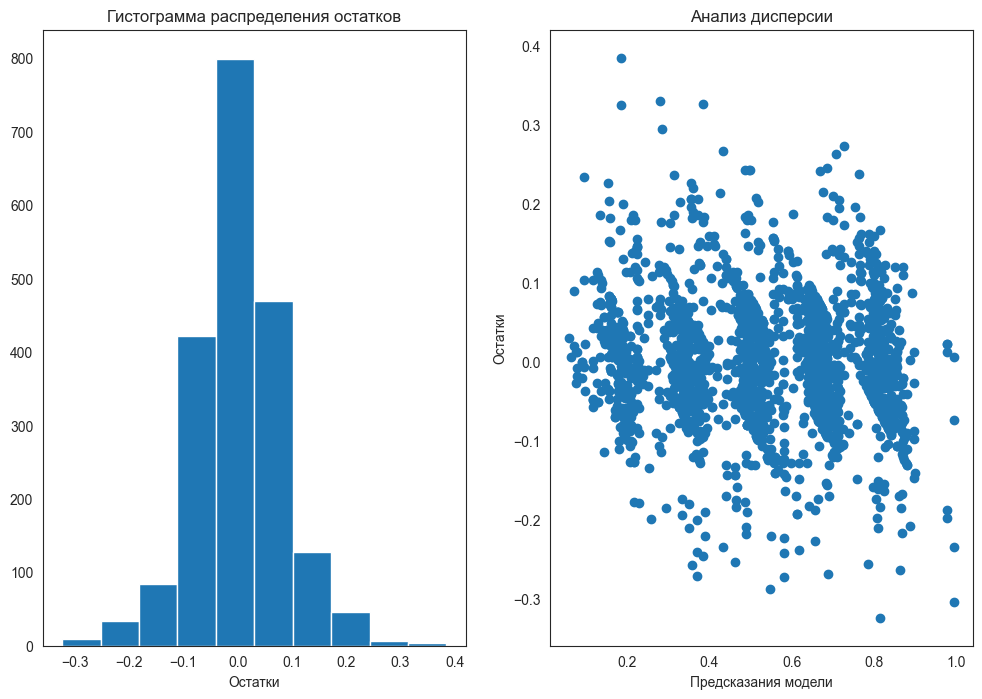

In [1046]:
# Проведем анализ остатков, предварительно рассчитаем остатки
residuals = y_test.values - y_pred_regr

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=y_pred_regr, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

# Вывод на экран
plt.show()

### Промежуточные выводы

* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков примерно равномерная, значения сосредоточены вокруг нуля, что свидетельствует об отсутствии систематических ошибок и адекватных предсказательных способностях модели

## Задача классификации

### Загрузка данных

In [1047]:
# Загрузим датафреймы
df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', sep=',')

df_test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [1048]:
# Инициализируем все датафреймы
df_train_quit = Data(df_train_quit)
df_test_target_quit = Data(df_test_target_quit)

# Составим словарь с именами датафреймов
datasets_clf = {
    'df_train_quit': df_train_quit,
    'df_test_target_quit': df_test_target_quit
}

# Передаем объекты для последующего вывода информации
manager_clf = DatasetManager(datasets_clf)

### Знакомство с данными

In [1049]:
manager_clf.print_head_all()

Датасет: df_train_quit



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


------------------------------
Датасет: df_test_target_quit



,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


------------------------------


### Анализ общей информации

In [1050]:
# Проанализируем общую информацию
manager_clf.show_info_all()

Датасет: df_train_quit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
------------------------------

Датасет: df_test_target_quit

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
-

### Промежуточные выводы

**df_train_quit**
- **Количество строк:** 4000  
- **Пропущенные значения:** отсутствуют
- **Необходимые преобразования:** отсутствуют
- **Типы данных:** корректировка не требуется  

---

**df_test_features_quit**
- **Количество строк:** 2000  
- **Пропущенные значения:** отсутствуют
- **Необходимые преобразования:** отсутствуют
- **Типы данных:** корректировка не требуется 

## Предобработка данных

### Обработка дубликатов

#### Обработка явных дубликатов

In [1051]:
# Посмотрим на явные дубликаты в датасетах
manager_clf.get_duplicate_rows_all()

Датасет: df_train_quit

------------------------------
Датасет: df_test_target_quit

------------------------------


Явные дубликаты не обнаружены

#### Поиск неявных дубликатов

In [1052]:
# Выводим уникальные значения в столбцах с строковым типом данных
manager_clf.show_unique_vals_string_columns_all()

Имя датасета: df_train_quit

Уникальные значения для столбца: dept
Количество уникальных значений: 5
['hr', 'marketing', 'purchasing', 'sales', 'technology']
------------------------------
Уникальные значения для столбца: level
Количество уникальных значений: 3
['junior', 'middle', 'sinior']
------------------------------
Уникальные значения для столбца: workload
Количество уникальных значений: 3
['high', 'low', 'medium']
------------------------------
Уникальные значения для столбца: last_year_promo
Количество уникальных значений: 2
['no', 'yes']
------------------------------
Уникальные значения для столбца: last_year_violations
Количество уникальных значений: 2
['no', 'yes']
------------------------------
Уникальные значения для столбца: quit
Количество уникальных значений: 2
['no', 'yes']
------------------------------

/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-

Имя датасета: df_test_target_quit

Уникальные значения для столбца: quit
Количество уникальных значени

Обнаружены опечатки:

**df_train_quit**
* столбец `level` опечатка в категории senior (указано sinior)

#### Обработка опечаток

In [1053]:
# Создадим список датасетов
df_process_string_columns_quit = [df_train_quit]

# Замена значений из словаря на корректный вариант
for data in df_process_string_columns_quit:
    data.process_string_columns(
        columns=['level'],
        replacements={'sinior':'senior'}
    )

Уникальные значения для столбца: level
Количество уникальных значений: 3
['junior', 'middle', 'senior']
------------------------------


### Промежуточные выводы

* Явные дубликаты не обнаружены
* Неявные дубликаты не обнаружены
* Опечатки исправлены

## Исследовательский анализ данных

### Описательная статистика

In [1054]:
# Посмотрим на параметры столбцов с числовыми значениями
manager_clf.describe_numeric_all()

Датасет: df_train_quit



,id,employment_years,supervisor_evaluation,salary
count,4000.00,4000.00,4000.00,4000.00
mean,552099.28,3.70,3.47,33805.80
std,260158.03,2.54,1.00,15152.42
min,100222.00,1.00,1.00,12000.00
25%,327785.75,2.00,3.00,22800.00
50%,546673.00,3.00,4.00,30000.00
75%,781497.75,6.00,4.00,43200.00
95%,952105.50,9.00,5.00,62400.00
99%,991329.44,10.00,5.00,79200.00
99.5%,994921.22,10.00,5.00,81600.00


------------------------------
Датасет: df_test_target_quit



,id
count,2000.00
mean,552765.21
std,253851.33
min,100298.00
25%,339052.00
50%,550793.00
75%,765763.75
95%,948432.10
99%,991523.58
99.5%,994718.61


------------------------------


Выбросы по рассматриваемым признакам не обнаружены

### Диаграммы размаха

#### Диаграммы размаха df_train_quit

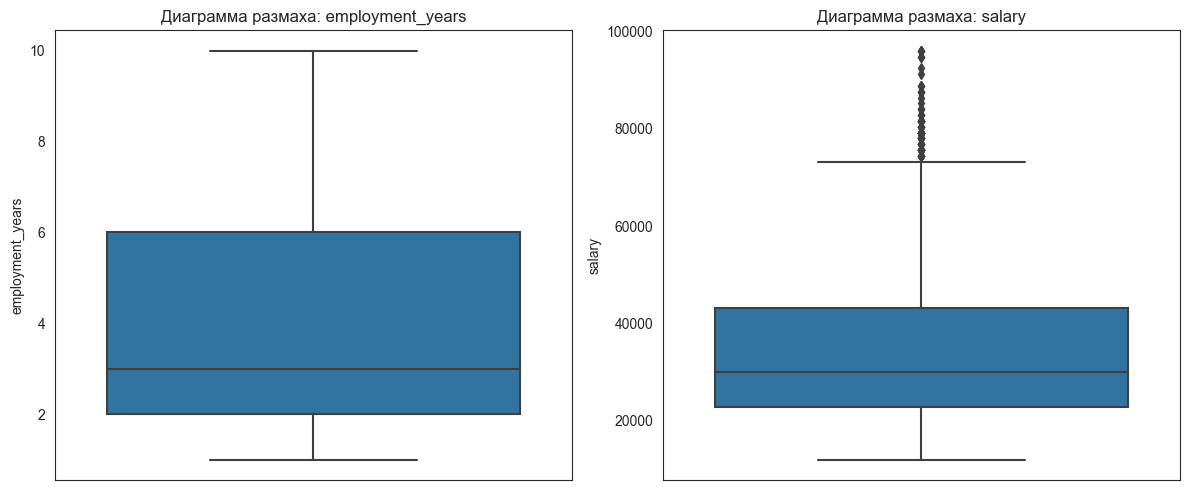

In [1055]:
# Создаем визуализатор
viz_train_quit = Visualizer(df_train_quit.data)

# Строим ящик с усами по признакам с непрерывным характером значений
viz_train_quit.boxplot(y=['employment_years', 'salary'])

#### Комментарии к диаграммам размаха

* Есть объяснимые выбросы по зарплате в районе выше 70_000 - очевидно, что самая высокая зарплата у мЕньшего числа сотрудников
* По длительности работы в компании медианное значение выборки в районе 3-х лет (имеет дискретный характер, будем строить барплот)

### Диаграммы распределения

#### Диаграммы распределения df_train_quit

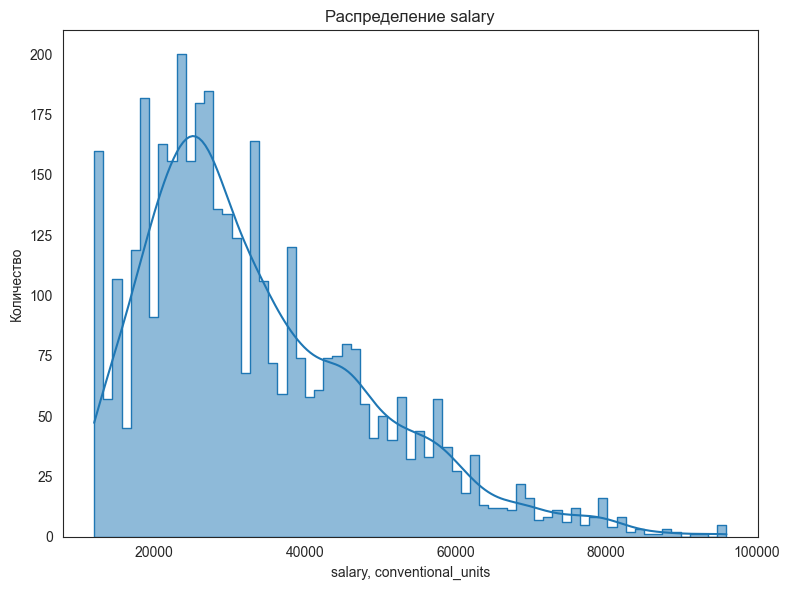

In [1056]:
# Строим график
viz_train_quit.histplot(x=['salary'], measurement=['conventional_units'])

**Проверка на нормальность распределения:**

In [1057]:
# Создаем список столбцов для проведения теста Шапиро-Уилка
df_train_quit_columns = ['salary']

# Проверим распределение на нормальность с помощью теста Шапиро-Уилка
for column in df_train_quit_columns:
    display(f'Результат теста Шапиро_Уилка для столбца {column}: {shapiro(df_train_quit.data[column])}')
    print('*' * 5)

'Результат теста Шапиро_Уилка для столбца salary: ShapiroResult(statistic=0.9303903579711914, pvalue=1.0861576500858803e-39)'

*****


**Вывод о нормальности распределения**
* p_value для значений всех столбцов значительно меньше 0.05, отвергаем нулевую гипотезу - значения по столбцу `salary` **НЕ распределены нормально**.

#### Комментарии к диаграммам распределения

* Значения по зарплате не распределены нормально
* По признаку `salary` имеется пик в районе 25-30 тыс. у.е.

### Построение диаграмм частот

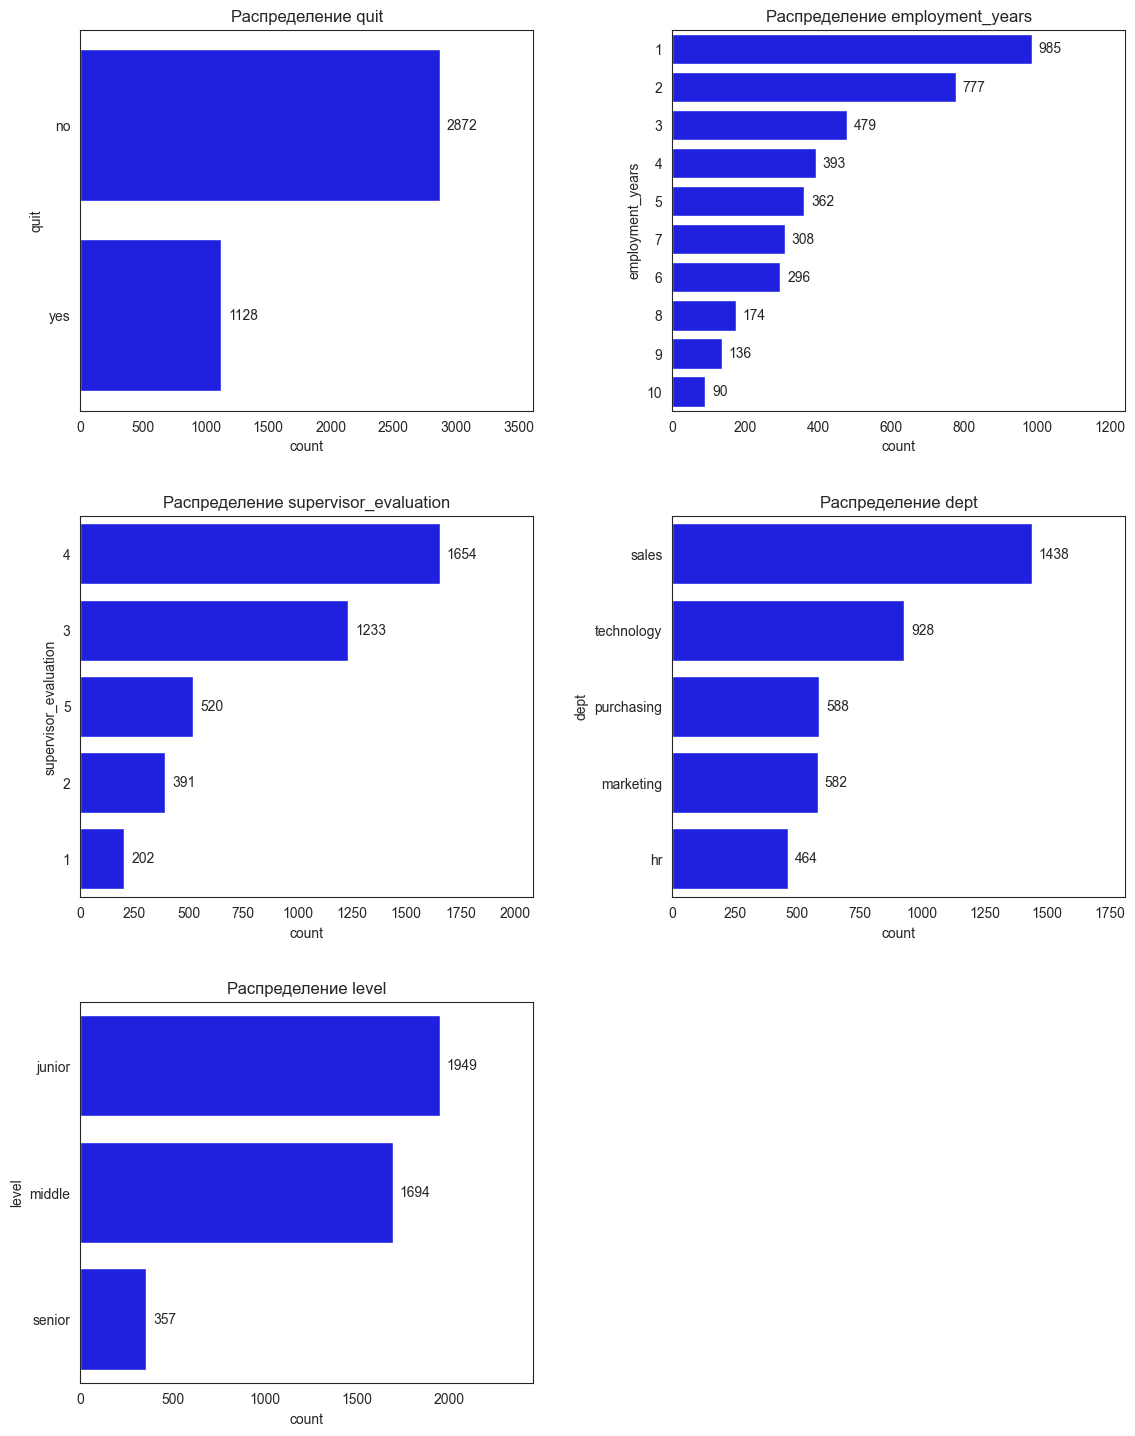

In [1058]:
# Строим график
viz_train_quit.barplot(x=['quit', 'employment_years','supervisor_evaluation', 'dept', 'level'])

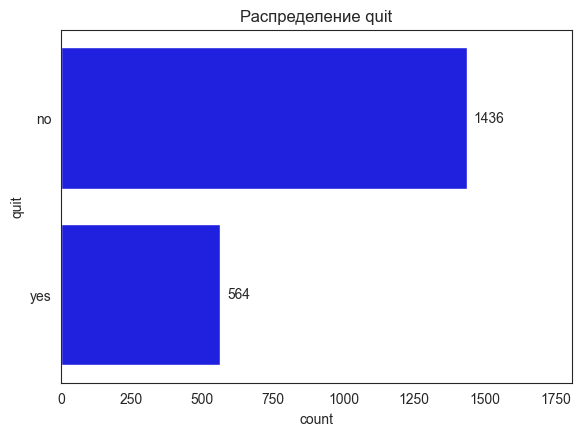

In [1059]:
# Инициализация класса
viz_test_target_quit = Visualizer(df_test_target_quit.data)

# Строим график
viz_test_target_quit.barplot(x=['quit'])

#### Комментарии к диаграммам частот

* Наблюдается дисбаланс классов у таргета `quit` - необходимо учесть этот факт при выборе метрики для оценки качества модели, а также в параметрах настройки модели
* НаибОльшую долю сотрудников, заполнивших анкеты, составили сотрудники с опытом работы 1-2 года в компании (чем больше опыт работы, тем меньше доля таких сотрудников в выборке)
* Чаще всего качество работы сотрудники было оценено в 3-4 балла (меньше всего сотрудников получило 1 балл, что логично, иначе были бы вопросы к департаменту подбора персонала)

#### Портрет уволившегося сотрудника (тренировочная выборка)

##### В разрезе отдела

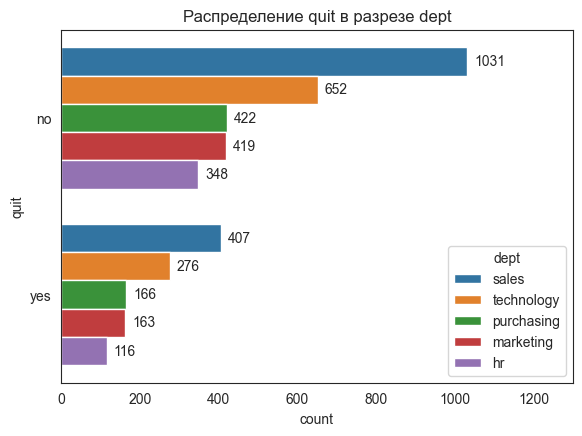

In [1060]:
# Строим график
viz_train_quit.barplot(x=['quit'], hue='dept')

##### В разрезе загрузки

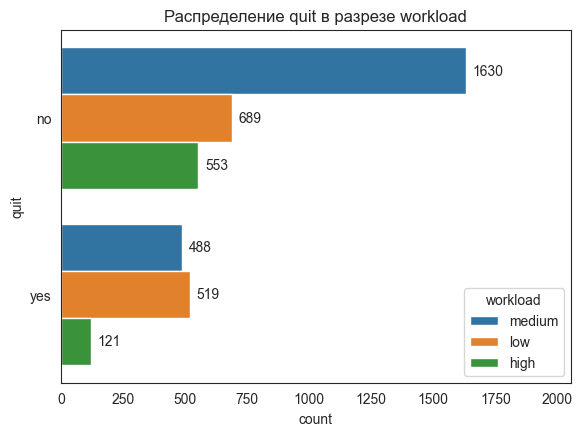

In [1061]:
# Строим график
viz_train_quit.barplot(x=['quit'], hue='workload')

##### Средняя зарплата

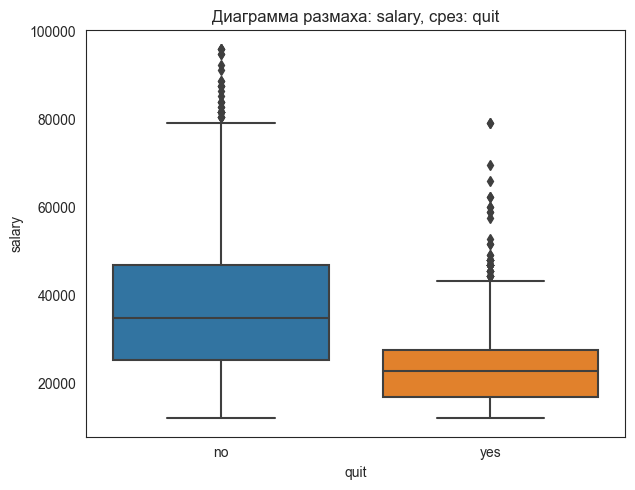

In [1062]:
# Строим ящик с усами по признакам с непрерывным характером значений
viz_train_quit.boxplot(y=['salary'], x='quit')

#### Распределение признака `job_satisfaction_rate` в разрезе признака `quit`

##### Подготовка данных

In [1063]:
# Сделаем столбец с id индексным
df_test_features_id_index = df_test_features.data.set_index('id')
df_test_target_id_index = df_test_target.data.set_index('id')
df_test_target_quit_id_index = df_test_target_quit.data.set_index('id')

# Объединим все целевые признаки в одном датасете с тестовой выборкой
df_test_full = df_test_features_id_index.join([df_test_target_id_index, df_test_target_quit_id_index])

# Смотрим на результат
df_test_full.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


In [1064]:
# Проверим, есть ли пустые значения
df_test_full.isna().sum()

dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
quit                     0
dtype: int64

Пропуски будут обрабатываться в пайплайне модели МО

##### Построение гистограмм

In [1065]:
# Инициализация класса для построения гистограммы
df_test_full = Data(df_test_full)

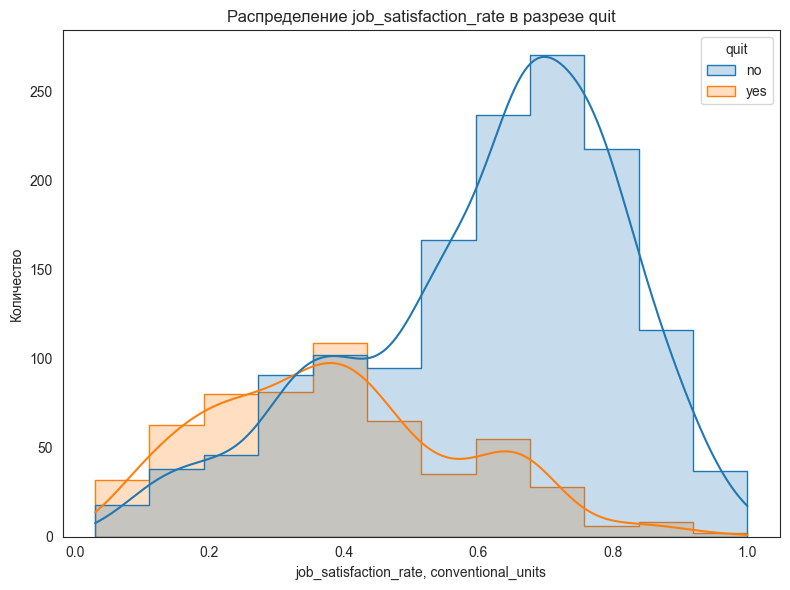

In [1066]:
# Создаем визуализатор
viz_test_full = Visualizer(df_test_full.data)

# Строим график
viz_test_full.histplot(x=['job_satisfaction_rate'], measurement=['conventional_units'], hue='quit')

Комментарий к гистограмме

* На гистограмме видна разница в пиковых значениях удовлетворенности работой уволившихся и оставшихся сотрудников:
    * большинство тех, кто уволился, оценивало работу на 0.4
    * большинство тех, кто остался, оценивает работу на 0.7
    * однако, здесь можно добавить, что среди оставшихся есть оценки 0.4, и количество таких оценок в абсолютном выражении даже немного превышает аналогичную оценку у уволившихся
    * мы можем сказать, что в целом те, кто уволился, были удовлетворены работой меньше, чем те, кто остался
    * об уровне зависимости между этими параметрами лучше скажет матрица корреляции

### Промежуточные выводы

**Диаграммы размаха**
* Есть объяснимые выбросы по зарплате в районе выше 70 тыс. у.е. - очевидно, что самая высокая зарплата у мЕньшего числа сотрудников
* По длительности работы в компании медианное значение выборки в районе 3-х лет (имеет дискретный характер, будем строить барплот)

**Диаграммы распределения**
* Значения по признаку `salary` не распределены нормально
* По признаку `salary` имеется пик в районе 25-30 тыс. у.е.

**Диаграммы частот**
* Наблюдается дисбаланс классов у таргета `quit` - необходимо учесть этот факт при выборе метрики для оценки качества модели, а также в параметрах настройки модели
* НаибОльшую долю сотрудников, заполнивших анкеты, составили сотрудники с опытом работы 1-2 года в компании (чем больше опыт работы, тем меньше доля таких сотрудников в выборке)
* Чаще всего качество работы сотрудники было оценено в 3-4 балла (меньше всего сотрудников получило 1 балл, что логично, иначе были бы вопросы к департаменту подбора персонала)

**Портрет уволившегося сотрудника**
* Уволившийся сотрудник с большей вероятностью:
    * работал в отделе продаж
    * имел низкий/средний уровень загруженности
    * средний уровень зарплаты был ниже, чем у тех, кто остался в компании

**Анализ распределения уровня удовлетворенности работой уволившихся и оставшихся сотрудникам. Результаты:**
* большинство тех, кто уволился, оценивало работу на 0.4
* большинство тех, кто остался, оценивает работу на 0.7
* однако, здесь можно добавить, что среди оставшихся есть оценки 0.4, и количество таких оценок в абсолютном выражении даже немного превышает аналогичную оценку у уволившихся
* мы можем сказать, что в целом те, кто уволился, были удовлетворены работой меньше, чем те, кто остался
* об уровне зависимости между этими параметрами лучше скажет матрица корреляции

**Подготовка данных на следующих этапах**
* Количественные непрерывные признаки: `salary` (следует масштабировать, т.к. шкалы значений между признаками отличаются)
* Количественные признаки с дискретной природой: `employment_years`
* Категориальные номинальные признаки: `dept` - необходимо преобразовать с помощью OHE
* Категориальные порядковые признаки: `supervisor_evaluation`, `level`, `workload` - необходимо преобразовать с помощью OrdinalEncoder
* Бинарные признаки: таргет `quit`, `last_year_promo`, `last_year_violations` - необходимо преобразовать в 0 (no) /1 (yes)
* Перед подготовкой данных следует построить матрицу корреляции признаков для отбора важных признаков и ислючения мультиколлениарности между признаками

## Добавление нового входного признака

### Подготовка тренировочных данных

In [1067]:
df_train_quit.data.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [1068]:
# Устанавливаем id в поле индекса и сортируем данные по индексу
X_train_quit_plus_jsr = df_train_quit.data.drop(['id', 'quit'], axis=1)

# Смотрим результат
X_train_quit_plus_jsr.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,middle,high,2,no,no,4,54000
1,sales,junior,medium,2,no,no,4,27600
2,purchasing,middle,medium,5,no,no,1,37200
3,sales,junior,medium,2,no,yes,3,24000
4,marketing,junior,medium,2,no,no,5,25200


In [1069]:
# Прогнозируем таргет `job_satisfaction_rate` на тренировочных данных второй задачи
y_pred_regr_2 = randomized_search.predict(X_train_quit_plus_jsr)

# Преобразуем спрогнозированный таргет в объект датафрейма
df_pred_regr_2 = pd.DataFrame(data=y_pred_regr_2, columns=['job_satisfaction_rate'])

# Добавляем спрогнозированные данные в тренировочную выборку
df_train_quit_plus_jsr = pd.concat([df_train_quit.data, df_pred_regr_2], axis=1)

# Инициализация класса
df_train_quit_plus_jsr = Data(df_train_quit_plus_jsr)

# Выводим результат на экран
df_train_quit_plus_jsr.print_head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.65
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.82
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.48
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.35
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.77


In [1070]:
# Проверяем, есть ли незаполненные значения
df_train_quit_plus_jsr.data.isna().sum()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
job_satisfaction_rate    0
dtype: int64

### Подготовка тестовых данных

In [1071]:
# Сбросим индекс тестовой выборки
df_test_features_temp = X_test.reset_index()

# Выводим результат на экран
df_test_features_temp.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [1072]:
# Преобразуем спрогнозированный таргет в объект датафрейма
df_pred_regr = pd.DataFrame(data=y_pred_regr, columns=['job_satisfaction_rate'])

# Добавляем спрогнозированные данные в тестовую выборку
df_test_quit_plus_jsr = pd.concat([df_test_features_temp, df_pred_regr], axis=1)

# Инициализация класса
df_test_quit_plus_jsr = Data(df_test_quit_plus_jsr)

# Выводим результат на экран
df_test_quit_plus_jsr.print_head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.87
1,100480,marketing,junior,low,4,no,no,4,16800,0.85
2,100503,purchasing,middle,high,5,no,no,4,55200,0.79
3,100610,sales,middle,medium,5,no,no,4,43200,0.81
4,100692,sales,middle,high,6,no,no,4,48000,0.70


In [1073]:
# Проверяем, есть ли незаполненные значения
df_test_quit_plus_jsr.data.isna().sum()

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

### Промежуточные выводы

* В тренировочные данных добавлен признак `job_satisfaction_rate`, спрогнозированный лучшей моделью регрессии из первой задачи
* В тестовые данные также добавлен признак `job_satisfaction_rate`, из результатов работы модели регрессии в первой задаче

## Корреляционный анализ

### Построение матрицы корреляции

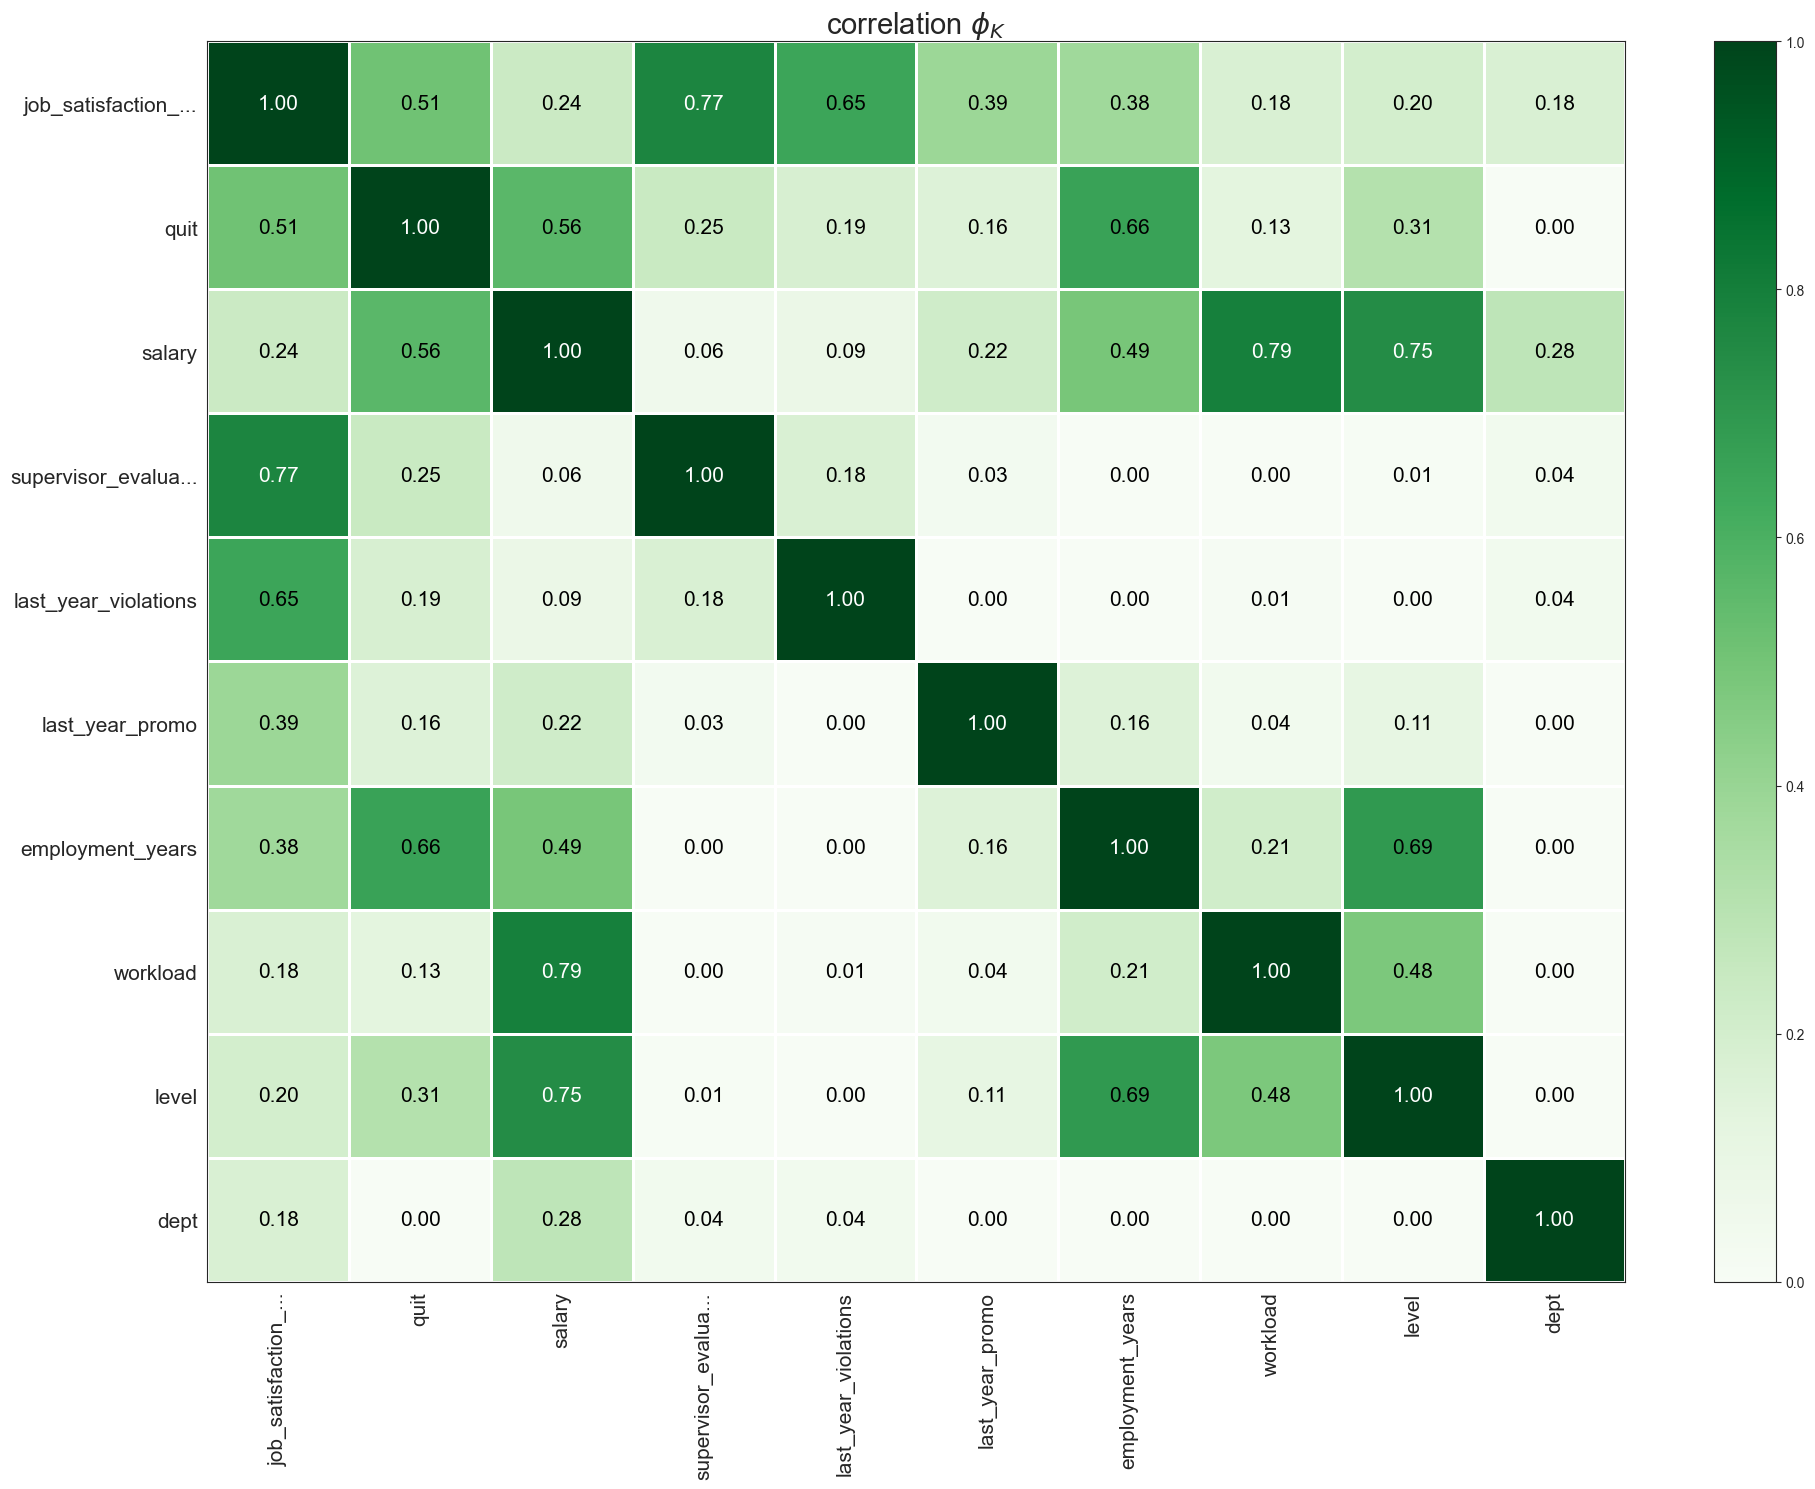

In [1074]:
# Создаём список с наименованиями непрерывных признаков
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']

# Считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_train_quit_plus_jsr.data.drop(['id'], axis=1), interval_cols=interval_cols)

# Визуализируем матрицу корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Промежуточные выводы

* Мультиколлениарность признаков не обнаружена
* Линейная связь между признаками `quit` и `job_satisfaction_rate` подтверждена и имеет средний уровень корреляции 0.51

## Моделирование

### Особенности данных

**Категориальные признаки**

* **OneHotEncoder** (3 признака), т.к.:
* это бинарные признаки (они подходят для преобразования с помощью OHE в силу своей простоты)
    * `last_year_promo`
    * `last_year_violations`
*  между категориями этих признаков нет естественной иерархии, а следовательно - математической связи:
    *  `dept` **(имеются незаполненные значения)**

--

* **OrdinalEncoder** (3 признака), т.к. признаки имеют ранговый характер:
  * `supervisor_evaluation` - оценка по бальной системе
  * `level` - квалификация персонала **(имеются незаполненные значения)**
  * `workload` - загруженность сотрудника

--

**Количественные признаки**

*Масштабирование* требуется для следующих признаков:

* `salary`
* `employment_years`
* `job_satisfaction_rate`

### Выбор метрики качества модели

* В качестве метрики для оценки качества модели выбрана метрика ROC-AUC — это всеохватывающая метрика качества классификации. 

* Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. 

* Метрика ROC-AUC у лучшей модели должна быть не меньше 0.91

### Формирование пайплайна

Строим модель бинарной классификации, т.к. необходимо предсказать значение бинарной величины - уход сотрудника из компании `quit`

In [1075]:
# ================== 0. Кодируем целевой признак ==================
le = LabelEncoder()
y_encoded = le.fit_transform(df_train_quit_plus_jsr.data['quit'])

# ================== 1. Разделяем выборку ==================

# Разделяем выборку на тестовую и тренировочную
X_train, X_val, y_train, y_val = train_test_split(
    df_train_quit_plus_jsr.data.drop(['quit', 'id'], axis=1),
    y_encoded,
    test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train_quit_plus_jsr.data['quit']) # Используем стратификацию целевого признака

# ================== 2. Определяем признаки ==================

# Создаем списки с названиями признаков
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept', 'supervisor_evaluation']
ord_columns = ['level', 'workload']
num_columns = ['salary', 'employment_years', 'job_satisfaction_rate']

# ================== 3. Пайплайны обработки ==================

# Функция для замены пробелов на NaN
replace_space = FunctionTransformer(lambda X: X.replace(' ', 'unknown'))

# OHE пайплайн
ohe_pipe = Pipeline([
    ('replace_space', replace_space),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
                    ]
                   )

# Ordinal пайплайн
ord_pipe = Pipeline(
    [
        ('replace_space', replace_space),
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                ['unknown', 'junior', 'middle', 'senior'],
                ['unknown', 'low', 'medium', 'high']
            ],
            handle_unknown='use_encoded_value', unknown_value=-1
        )
        )
    ]
)

# Создаём общий пайплан для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# ================== 4. Финальный пайплайн ==================

# Создаём итоговый пайплан: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# ================== 5. Сетка параметров ==================

param_grid = [
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier()],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C':range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели SVC()
    {
        'models':[SVC(
            kernel='poly',
            degree=6,
            probability=True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

# ================== 6. RandomizedSearchCV ==================

# Инициализируем start для замера времени
start = time.time()

# Инициализируем класс для подбора гиперпараметров на 10 итераций
# значение кросс-валидации 5, метрика roc-auc
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучаем модель
randomized_search_2.fit(X_train, y_train)

# Считаем, сколько секунд прошло с начала запуска
randomized_search_search_time = time.time() - start
print(f'Search time:{randomized_search_search_time}')

# Выводим лучшую модель и метрики при обучении
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print (f'Метрика ROC-AUC лучшей модели на тренировочной выборке: {randomized_search_2.best_score_:.2f}')

# ================== 7. Оценка на валидационной выборке ==================

# Проверим работу модели на валидационной выборке
# Рассчитаем прогноз на валидационных данных
y_val_pred_clf = randomized_search_2.predict_proba(X_val)[:,1]
print(f'Метрика ROC-AUC на валидационной выборке: {roc_auc_score(y_val, y_val_pred_clf):.2f}')

# ================== 8. Стратифицированная CV на всём датасете ==================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    randomized_search_2.best_estimator_,
    df_train_quit_plus_jsr.data.drop(['quit'], axis=1),
    y_encoded,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print(f'ROC-AUC по стратифицированным фолдам:', [f'{score:.2f}' for score in cv_scores])
print(f'Средний ROC-AUC: {cv_scores.mean():.2f}')
print(f'Стандартное отклонение: {cv_scores.std():.4f}')

# ================== 7. Оценка на тестовой выборке ==================

# Индексируем по 'id' и сортируем
X_test = df_test_quit_plus_jsr.data.set_index('id').sort_index()
y_test = df_test_target_quit.data.set_index('id')['quit'].sort_index()

# Проверка индексов
assert (X_test.index == y_test.index).all()

# Проверим работу модели на тестовой выборке
# Рассчитаем прогноз на тестовых данных
y_test_pred_clf = randomized_search_2.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_clf):.2f}')

Search time:0.8548440933227539
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('replace_space',
                                                                   FunctionTransformer(func=<function <lambda> at 0x144a5fee0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                     

### Промежуточные выводы

* Для обучения выбраны 4 модели: DecisionTreeClassifier(), LogisticRegression(), SVC(), KNeighborsClassifier()
* Лучшей на обучении стала модель LogisticRegression()
* Метрика ROC-AUC:
    * на тренировочной выборке: 0.91
    * на валидационной выборке: 0.92
    * по стратифицированным фолдам тренировочного датасета: [0.92, 0.92, 0.91, 0.92, 0.93]
    * на тестовой выборке: 0.91
* Условие задачи по значению метрики <= 0.91 выполнено

## Анализ важности признаков

### Подготовка признаков для вывода на графики

In [1076]:
# Получаем препроцессор из пайплайна
preprocessor = randomized_search_2.best_estimator_.named_steps['preprocessor']

# Преобразуем тренировочные и валидационные данные
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

# Получаем модель
model = randomized_search_2.best_estimator_.named_steps['models']

# Рассчитываем permutation importance
result = permutation_importance(
    model,
    X_val_transformed,
    y_val,
    scoring='roc_auc'
)

# Собираем названия признаков правильно
# Сначала получаем все преобразованные признаки
all_features = []

# Добавляем OHE признаки
ohe_features = preprocessor.named_transformers_['ohe'].named_steps['ohe'].get_feature_names(ohe_columns)
all_features.extend(ohe_features)

# Добавляем Ordinal признаки (используем исходные названия)
all_features.extend(ord_columns)

# Добавляем числовые признаки
all_features.extend(num_columns)

# Добавляем оставшиеся признаки (если есть)
# Проверяем, все ли признаки учтены
remaining_features = X_val.columns[~X_val.columns.isin(ohe_columns + ord_columns + num_columns)]
all_features.extend(remaining_features)

# Проверяем соответствие размеров
assert X_val_transformed.shape[1] == len(all_features)
assert len(all_features) == len(result['importances_mean'])

# Создаем DataFrame с важностью признаков
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': result['importances_mean']
})

feature_importance = feature_importance.sort_values('Importance', ascending=True)

In [1077]:
# Дополнительная проверка
print("Проверка соответствия размеров:")
print(f"Длина all_features: {len(all_features)}")
print(f"Длина importances_mean: {len(result['importances_mean'])}")
print(f"Форма преобразованных данных: {X_val_transformed.shape}")

print("Длина features_names:", len(all_features))
print("Длина importances_mean:", len(result['importances_mean']))

print("Форма преобразованных данных:", X_val_transformed.shape)
print("Количество признаков:", len(all_features))
print("Длина importances_mean:", len(result['importances_mean']))
print("Пропуски в importances_mean:", np.isnan(result['importances_mean']).sum())
print("Тип importances_mean:", type(result['importances_mean']))
print("Тип all_features:", type(all_features))

Проверка соответствия размеров:
Длина all_features: 19
Длина importances_mean: 19
Форма преобразованных данных: (1000, 19)
Длина features_names: 19
Длина importances_mean: 19
Форма преобразованных данных: (1000, 19)
Количество признаков: 19
Длина importances_mean: 19
Пропуски в importances_mean: 0
Тип importances_mean: <class 'numpy.ndarray'>
Тип all_features: <class 'list'>


### График важности признаков

[ 1.22541659 -0.37741011  0.          0.13688844 -0.06467031  0.
  0.06742225 -0.13543396  0.19009231  0.3500972   0.          0.24613047
 -0.60101366 -1.20918267 -1.40858271 -0.14712958 -1.02727074 -1.42006557
 -1.37436768]


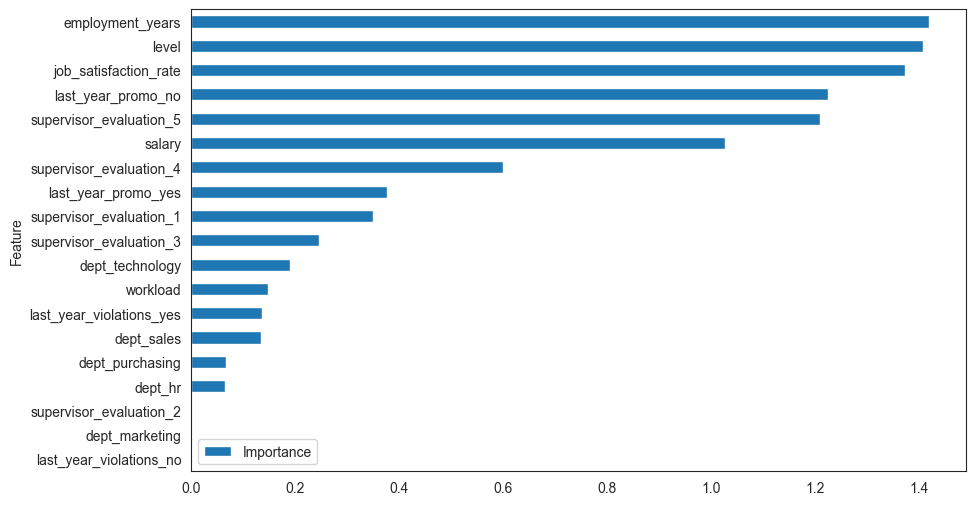

In [1078]:
# Получаем модель из пайплайна
model = randomized_search_2.best_estimator_.named_steps['models']

# Определяем значения коэффициентов признаков для вывода на график
coefficients = model.coef_[0]
print(coefficients)

# Определяем значимость признаков
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=True)

# Строим график важности признаков
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

##### Комментарий к граифку важности признаков

По результатам построения графика важности признаков обученной модели выявлено, что наиболее важными признаками относительно целевого `quit` (увольнение сотрудника из компании) являются:
* Длительность работы в компании (в годах)
* Уровень занимаемой должности
* Уровень удовлетворённости сотрудника работой в компании
* Было ли повышение за последний год
* Оценка качества работы сотрудника, которую дал руководитель
* Ежемесячная зарплата сотрудника

---

* Эти же признаки имели самую высокую корреляцию, если вернуться к матрице корреляции, за исключением показателя повышения работника в прошлом году и оценки качестве работы руководителем - значит, модель выявила какие-то новые зависимости признаков с таргетом
* Посмотрим, подтвердится ли важность этих признаков при рандомизации

### График важности признаков с учетом рандомизации

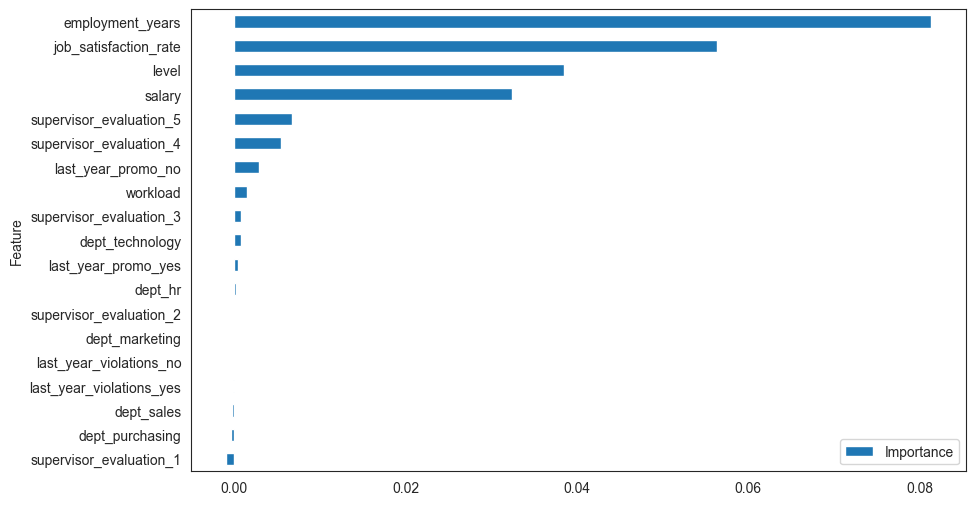

In [1079]:
# Инициализируем перестановку признакой у модели
result = permutation_importance(model, X_val_transformed, y_val, scoring='roc_auc')

# Определяем значимость признаков
feature_importance = pd.DataFrame({'Feature': all_features, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

# Строим график важности признаков
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

##### Комментарии к графику

На графике видно, что результаты несколько изменились:

**Следующие признаки значительно снизили своё влияние на таргет**:
* Было ли повышение за последний год
* Оценка качества работы сотрудника, которую дал руководитель

**Следующие показатели остались важными**:
* Длительность работы в компании (в годах)
* Уровень занимаемой должности
* Уровень удовлетворённости сотрудника работой в компании
* Ежемесячная зарплата сотрудника

### График важности признаков по методу SHAP

#### График общей важности признаков

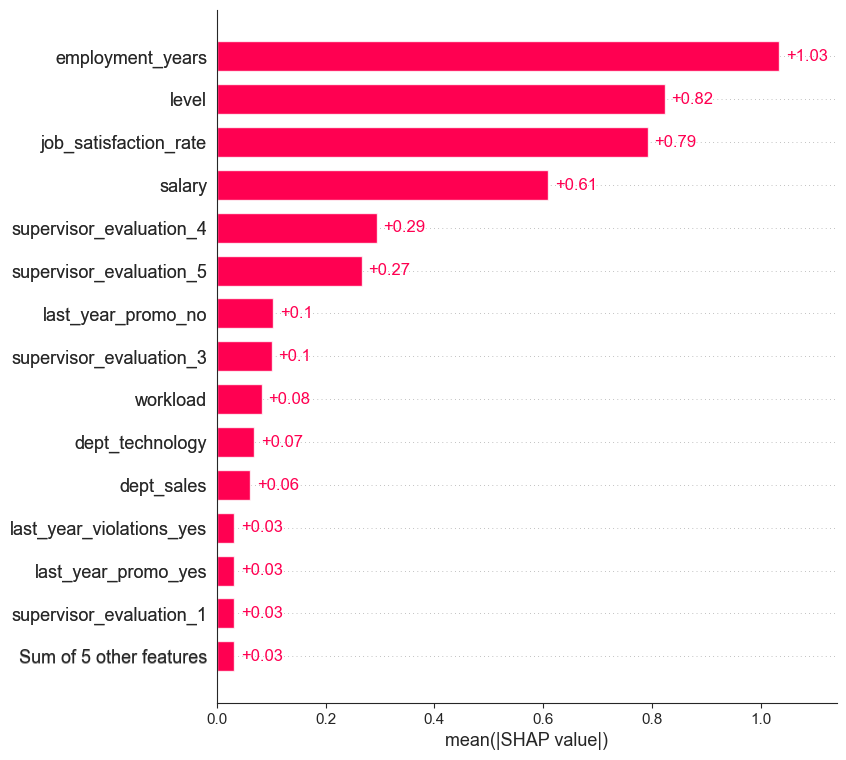

In [1080]:
explainer = shap.LinearExplainer(model, pd.DataFrame(X_train_transformed, columns=all_features))
shap_values = explainer(pd.DataFrame(X_val_transformed, columns=all_features))

# строим график shap
shap.plots.bar(shap_values, max_display=15, show=False)
plt.show()

##### Комментарий к графику

* Результаты оценки важности признаков после рандомизации подтвердились

#### График важности признаков Beeswarm

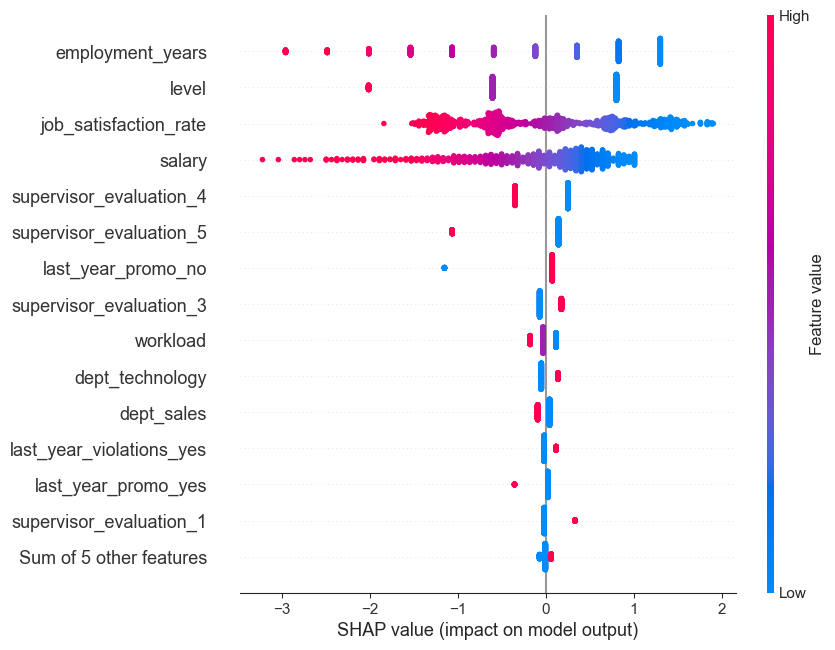

In [1081]:
# Построим график влияния признаков на каждое предсказание модели
shap.plots.beeswarm(shap_values, max_display=15)

### Комментарии к графику Beeswarm

Здесь мы видим любопытные результаты.

**Увеличение значений следующих признаков повышает вероятность увольнения сотрудника из компании:**
* Отсутствие повышения в прошлом году
* Получение оценки качества работы сотрудника ниже 4-х

**Признаки, малые значения (категории / уровни) которых, повышают вероятность увольнения сотрудника из компании:**
* Длительность работы в компании
* Уровень занимаемой должности
* Уровень удовлетворённости сотрудника работой в компании
* Ежемесячная зарплата сотрудника

## Сегментация сотрудников

Посмотрим на уволенных сотрудников в разрезе признаков: 
* Уровень занимаемой должности
* Уровень удовлетворённости сотрудника работой в компании
* Ежемесячная зарплата сотрудника

In [1082]:
# Выделим сотрудников, уволившихся из компании
df_train_quit_yes = df_train_quit_plus_jsr.data.query('quit == "yes"')

# Посмотрим на результат
df_train_quit_yes.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.35
5,699916,sales,junior,low,1,no,yes,3,18000,yes,0.11
9,613206,technology,middle,medium,2,no,no,3,45600,yes,0.24
24,468145,technology,junior,medium,2,no,no,3,30000,yes,0.37
25,982346,marketing,junior,medium,3,no,no,3,30000,yes,0.48


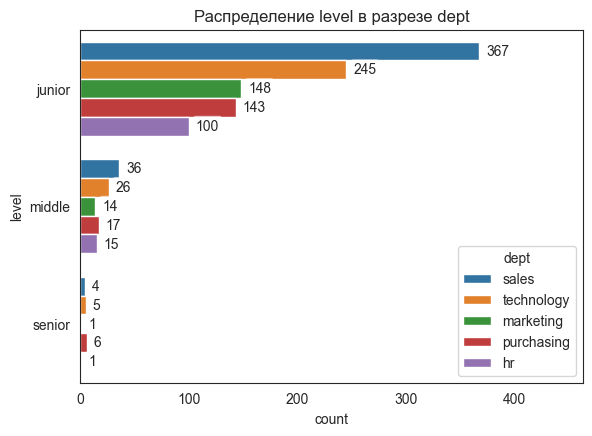

In [1083]:
# Посмотрим, как выглядит выборка в разрезе уровней занимаемой должности
# Инициализируем объект для визуализации
viz_quit_yes = Visualizer(df_train_quit_yes)

# Выводим график на экран
viz_quit_yes.barplot(x='level', hue='dept')

Мы видим, что абсолютное большинство уволенных сотрудников с уровнем `junior`, сконцентрируемся на них

In [1084]:
# Отфильтруем датасет, оставим только джуниоров
df_train_quit_yes_jun = df_train_quit_yes.query('level == "junior"')

# Смотрим на результат
df_train_quit_yes_jun.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.35
5,699916,sales,junior,low,1,no,yes,3,18000,yes,0.11
24,468145,technology,junior,medium,2,no,no,3,30000,yes,0.37
25,982346,marketing,junior,medium,3,no,no,3,30000,yes,0.48
28,157780,sales,junior,low,3,no,no,4,12000,yes,0.64


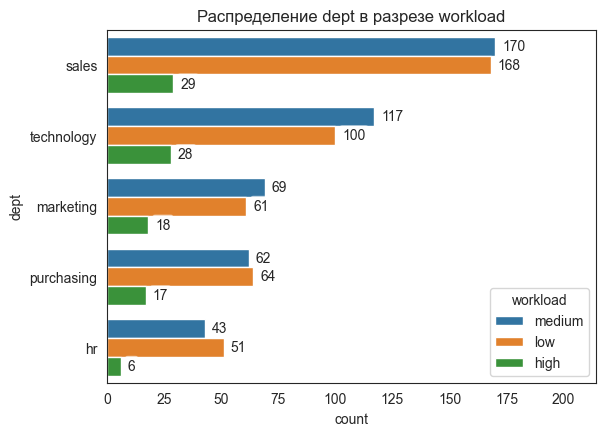

In [1085]:
# Посмотрим, как выглядит выборка в разрезе уровней занимаемой должности
# Инициализируем объект для визуализации
viz_quit_yes_jun = Visualizer(df_train_quit_yes_jun)

# Выводим график на экран
viz_quit_yes_jun.barplot(x='dept', hue='workload')

* Видим, казалось бы, парадоксальный момент - большинство уволившихся либо загружены слабо, либо загружены на среднем уровне
* Оставим эти две группы загруженности для дальнейшего анализа

In [1086]:
# Формируем сводную таблицу
(df_train_quit_yes_jun\
    .query('workload != "high"').pivot_table(index=['workload', 'last_year_promo'], values=['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'])
)

,,employment_years,job_satisfaction_rate,salary,supervisor_evaluation
workload,last_year_promo,,,,
low,no,1.60,0.42,15878.38,3.16
medium,no,1.64,0.35,25835.14,2.85


### Выводы и рекомендации

**Выводы**

Какие можно сделать выводы, исходя из обученной модели и результатов сегментации:

* Что уволенные сотрудники в большинстве своём уровня `junior`, что означает, что у них небольшой опыт работы в компании и зарплата ниже медианного уровня по компании
* Большинство сотрудников этого сегмента:
    * имели среднюю или низкую загруженность
    * не повышались в должности при среднем опыте работы более 1,5 лет
    * были оценены своим руководителем ниже 4-х баллов (что, исходя из обученной модели, является важным маркером для увольнения)
    * были удовлетворены своей работой на уровне 0.4 и ниже (это значение является медианным для тех, кто увольняется)


**Рекомендации**

* В части обогащения датасета новыми признаками: расшить оценку работы руководителям до конкретных компетенций оценки (проактивность, достижения на проектах, участие в научных конкурсах, курсы повышения квалификации), чтобы понимать объективность суждений руководителей
* Расшить удовлетворенность работой на составлющие: возможно, так - добавить оценку удовлетворенности задачами в рамках работы, взаимодействием с проектной компандой, руководителем, социальные льготы, ДМС
* Посмотреть критически на программу адаптации сотрудников 'junior', ввести программу менторства и доплаты со стороны коллег высшей квалификации
* Пересмотреть подход по найму новых сотрудников - возможно, есть какие-то маркеры отбора, которых не хватает (софт скилы или хард скилы)
* Предусмотреть пересмотр заработной платы для сегмента 'junior' в случае прохождения испытательного срока на оценку 'отлично' или 'выше ожиданий', посмотреть на возможность внедрения такой оценки по итогам испытательного срока

## Общий вывод

**ЗАДАЧА РЕГРЕССИИ (таргет - уровень удовлетворенности работой)**

**Итоги анализа общей информации**

**df_train**
- **Количество строк:** 4000  
- **Пропущенные значения:** есть (`dept` – 6, `level` – 4) - обрабатывать будем на этапе формирования пайплайна модели
- **Необходимые преобразования:**  
  - Обработать пропущенные значения (`dept`, `level`)  
- **Типы данных:** корректировка не требуется  

-/-

**df_test_features**
- **Количество строк:** 2000  
- **Пропущенные значения:** есть (`dept` – 2, `level` – 1) - обрабатывать будем на этапе формирования пайплайна модели
- **Необходимые преобразования:**  
  - Обработать пропущенные значения (`dept`, `level`)  
- **Типы данных:** корректировка не требуется  

-/-

**df_test_target**
- **Количество строк:** 2000  
- **Пропущенные значения:** отсутствуют  
- **Необходимые преобразования:** отсутствуют  
- **Типы данных:** корректировка не требуется  

---

**Итоги предобработки данных**

* Явные дубликаты не обнаружены
* Неявные дубликаты не обнаружены
* Опечатки исправлены
* Обнаружены некорректные значения ' ' в столбцах `dept`, `workload`в тестовой выборке (в тренировочной выборке таких значений нет)

---

**Итоги исследовательского анализа данных**

**Диаграммы размаха**
* Есть объяснимые выбросы по зарплате в районе выше 70 тыс. у.е. - очевидно, что самая высокая зарплата у мЕньшего числа сотрудников
* По длительности работы в компании медианное значение выборки в районе 3-х лет (имеет дискретный характер, будем строить барплот)
* Медианное значение уровня удовлетворённости работой в районе чуть выше 0.5
* У тренировочных и тестовых данных схожий диапазон значений и схожие медианные значения

**Диаграммы распределения**
* Все непрерывные величины датасетов не распределены нормально
* По признаку `salary` имеется пик в районе 25-30 тыс. у.е.
* Значения по признаку `job_satisfaction_rate` принимают унимодальный вид с пиковыми значениями в районе 0.4 и 0.7 - это значит, что в выборке есть 2 крупные группы сотрудников: с высоким (0.7) и низким (0.4) уровнем удовлетворенности работой

**Диаграммы частот**
* НаибОльшую долю сотрудников, заполнивших анкеты, составили сотрудники с опытом работы 1-2 года в компании (чем больше опыт работы, тем меньше доля таких сотрудников в выборке)
* Чаще всего качество работы сотрудники было оценено в 3-4 балла (меньше всего сотрудников получило 1 балл, что логично, иначе были бы вопросы к департаменту подбора персонала)

**Диаграммы рассеяния**
* Построены диаграммы рассения - зависимость уровня удовлетворенности работой от зарплаты в разрезе квалификации и уровня загрузки работника:
    * чем выше квалификация, тем меньше линейная зависимость между зарплатой и уровнем удовлетворенности работника
    * чем выше загрузка работника, тем меньше линейная зависимость между зарплатой и уровнем удовлетворенности работника

**Подготовка данных на следующих этапах**
* Количественные непрерывные признаки: `salary` (следует масштабировать, т.к. шкалы значений между признаком и таргетом отличаются), `job_satisfaction_rate` - таргет
* Количественные признаки с дискретной природой: `employment_years`
* Категориальные номинальные признаки: `dept` - необходимо преобразовать с помощью OHE
* Категориальные порядковые признаки: `supervisor_evaluation`, `level`, `workload` - необходимо преобразовать с помощью OrdinalEncoder
* Бинарные признаки: `last_year_promo`, `last_year_violations` - необходимо преобразовать в 0 (no) /1 (yes)
* Перед подготовкой данных следует построить матрицу корреляции признаков для отбора важных признаков и ислючения мультиколлениарности между признаками

---

**Итоги корреляционного анализа данных**

* Мультиколлениарность признаков не обнаружена
* Самые важные признаки:
    * ежемесячная зарплата сотрудника
    * нарушал ли сотрудник трудовой договор за последний год
    * длительность работы в компании (в годах)

---

**Итоги моделирования**

* В качестве метрики качества модели выберем показатель SMAPE, для этого создадим функцию по расчету этой метрики
* SMAPE — это метрика, которая измеряет ошибку прогнозов в процентном выражении, но делает это симметрично для наблюдения и прогноза.
* Для обучения выбраны 2 модели: LinearRegression() и DecisionTreeRegressor()
* Лучшей на обучении стала модель DecisionTreeRegressor()
* Метрика SMAPE:
    * на тренировочной выборке: 15
    * по стратифицированным фолдам тренировочного датасета: ['15', '14', '15', '15', '14']
    * на тестовой выборке: 14
* Условие задачи по значению метрики <= 15 выполнено

---

**Анализ остатков**

* Распределение остатков близко к симметричному унимодальному без выраженного смещения
* Дисперсия остатков примерно равномерная, значения сосредоточены вокруг нуля, что **свидетельствует об отсутствии систематических ошибок и адекватных предсказательных способностях модели**

---

**ЗАДАЧА КЛАССИФИКАЦИИ (таргет - отток сотрудников)**

**Итоги анализа общей информации**

**df_train_quit**
- **Количество строк:** 4000  
- **Пропущенные значения:** отсутствуют
- **Необходимые преобразования:** отсутствуют
- **Типы данных:** корректировка не требуется  

-/-

**df_test_features_quit**
- **Количество строк:** 2000  
- **Пропущенные значения:** отсутствуют
- **Необходимые преобразования:** отсутствуют
- **Типы данных:** корректировка не требуется

---

**Итоги предобработки данных**

* Опечатки исправлены
* Явные дубликаты не обнаружены
* Неявные дубликаты не обнаружены

---

**Итоги исследовательского анализа данных**

**Диаграммы частот**
* Наблюдается дисбаланс классов у таргета `quit` - необходимо учесть этот факт при выборе метрики для оценки качества модели, а также в параметрах настройки модели
* НаибОльшую долю сотрудников, заполнивших анкеты, составили сотрудники с опытом работы 1-2 года в компании (чем больше опыт работы, тем меньше доля таких сотрудников в выборке)
* Чаще всего качество работы сотрудники было оценено в 3-4 балла (меньше всего сотрудников получило 1 балл, что логично, иначе были бы вопросы к департаменту подбора персонала)

**Портрет уволившегося сотрудника**
* Уволившийся сотрудник с большей вероятностью:
    * работал в отделе продаж
    * имел низкий/средний уровень загруженности
    * средний уровень зарплаты был ниже, чем у тех, кто остался в компании

**Анализ распределения уровня удовлетворенности работой уволившихся и оставшихся сотрудникам. Результаты:**
* большинство тех, кто уволился, оценивало работу на 0.4
* большинство тех, кто остался, оценивает работу на 0.7
* однако, здесь можно добавить, что среди оставшихся есть оценки 0.4, и количество таких оценок в абсолютном выражении даже немного превышает аналогичную оценку у уволившихся
* мы можем сказать, что в целом те, кто уволился, были удовлетворены работой меньше, чем те, кто остался
* об уровне зависимости между этими параметрами лучше скажет матрица корреляции

---

**Добавление нового входного признака**
* В тренировочные данных добавлен признак `job_satisfaction_rate`, спрогнозированный лучшей моделью регрессии из первой задачи
* В тестовые данные также добавлен признак `job_satisfaction_rate`, из результатов работы модели регрессии в первой задаче

---

**Итоги корреляционного анализа данных**

* Мультиколлениарность признаков не обнаружена
* Линейная связь между признаками `quit` и `job_satisfaction_rate` подтверждена и имеет средний уровень корреляции 0.51
* Также высокую корреляцию с таргетом имеет:
    * ежемесячная зарплата сотрудника
    * длительность работы в компании (в годах)

---

**Итоги моделирования**


* В качестве метрики для оценки качества модели выбрана метрика ROC-AUC — это всеохватывающая метрика качества классификации
* Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного
* Для обучения выбраны 4 модели: DecisionTreeClassifier(), LogisticRegression(), SVC(), KNeighborsClassifier()
* Лучшей на обучении стала модель LogisticRegression()
* Метрика ROC-AUC:
    * на тренировочной выборке: 0.91
    * на валидационной выборке: 0.92
    * по стратифицированным фолдам тренировочного датасета: [0.92, 0.92, 0.91, 0.92, 0.93]
    * на тестовой выборке: 0.91
* Условие задачи по значению метрики <= 0.91 выполнено

---

**Итоги анализа важности признаков**

**Увеличение значений следующих признаков повышает вероятность увольнения сотрудника из компании:**
* Отсутствие повышения в прошлом году
* Получение оценки качества работы сотрудника ниже 4-х

**Признаки, малые значения (категории / уровни) которых, повышают вероятность увольнения сотрудника из компании:**
* Длительность работы в компании
* Уровень занимаемой должности
* Уровень удовлетворённости сотрудника работой в компании
* Ежемесячная зарплата сотрудника

---

**Итоги сегментации сотрудников**

* Уволенные сотрудники в большинстве своём уровня `junior`, что означает, что у них небольшой опыт работы в компании и зарплата ниже медианного уровня по компании
* Большинство сотрудников этого сегмента:
    * имели среднюю или низкую загруженность
    * не повышались в должности при среднем опыте работы более 1,5 лет
    * были оценены своим руководителем ниже 4-х баллов (что, исходя из обученной модели, является важным маркером для увольнения)
    * были удовлетворены своей работой на уровне 0.4 и ниже (это значение является медианным для тех, кто увольняется)

---

**Рекомендации**

* В части обогащения датасета новыми признаками: конкретизировать оценку работы сотрудников по параметрам оценки (проактивность, достижения на проектах, участие в научных конкурсах, курсы повышения квалификации), чтобы понимать объективность суждений руководителей
* Расшить удовлетворенность работой на составлющие: возможно, так - добавить оценку удовлетворенности задачами в рамках работы, взаимодействием с проектной командой, руководителем, социальные льготы, ДМС
* Посмотреть критически на программу адаптации сотрудников 'junior', ввести программу менторства и мотивацию со стороны коллег высшей квалификации для передачи опыта
* Пересмотреть подход по найму новых сотрудников - возможно, есть какие-то маркеры отбора, которых не хватает (софт скилы или хард скилы)
* Предусмотреть возможность пересмотра заработной платы для сегмента 'junior' в случае прохождения испытательного срока на оценку 'отлично' или 'выше ожиданий', посмотреть на возможность внедрения такой оценки по итогам испытательного срока